<div style="border-radius:20px; padding: 15px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">
    
This project performs customer segmentation on an e-commerce dataset using clustering techniques, followed by a recommendation system based on the resulting clusters.We aim to segment ecommerce customers into distinct groups based on their purchase behavior. By leveraging clustering algorithms on RFM features (e.g. Recency, Frequency, Monetary), we will:

- Identify high-value customers for targeted marketing campaigns
- Discover at-risk or low-engagement segments
- Provide actionable insights to improve retention and revenue

<div style=" background-color: #ff4d6d; color:#ffffff; padding: 4px; border-radius: 15px; text-align: center; font-size: 110%; font-family: sans-serif">

## Step 1 | Import Libraries and Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from collections import Counter
from yellowbrick.cluster import SilhouetteVisualizer

In [2]:
# Set display options for pandas
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 100)      # Limit rows for preview
pd.set_option('display.float_format', '{:.2f}'.format)  # Format floats to 2 decimal places

# Set theme for visualizations
pink_palette = ['#ffb3c1', '#ff8fa3', '#ff4d6d', '#c9184a', '#9d4edd']
sns.set_theme(context='notebook', style="whitegrid", font='sans-serif', font_scale=1.2, palette=pink_palette)
# sns.set_palette(sky_blue_palette)  # Set Seaborn palette
plt.rcParams['figure.figsize'] = (10, 6)  # Default figure size
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.grid'] = True

In [3]:
dataset = pd.read_csv("Costumer Dataset.csv", encoding="ISO-8859-1")

<div style=" background-color: #ff4d6d; color:#ffffff; padding: 4px; border-radius: 15px; text-align: center; font-size: 110%; font-family: sans-serif">

## Step 2 | Dataset Overview

In [4]:
dataset.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.00,United Kingdom


<div style="border-radius:20px; padding: 15px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">
    
**Dataset Features:**
* InvoiceNo: Uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* StockCode: Uniquely assigned to each distinct product.(Reperesent Product Code)
* Description: Description of each product.(Product name)
* Quantity: Number of a product in transaction.
* InvoiceDate: The day and time when each transaction was generated.
* UnitPrice: Product price per unit(sterling).
* CustomerID: Identifier number uniquely assigned to each customer.
* Country: The name of the country where each customer resides.

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
print("Shape of dataset(N of Sampels and N of features):")
dataset.shape

Shape of dataset(N of Sampels and N of features):


(541909, 8)

In [7]:
print("Numerical Featuers Summary:\n")
dataset.describe().T

Numerical Featuers Summary:



,count,mean,std,min,25%,50%,75%,max
Quantity,541909.00,9.55,218.08,-80995.00,1.00,3.00,10.00,80995.00
UnitPrice,541909.00,4.61,96.76,-11062.06,1.25,2.08,4.13,38970.00
CustomerID,406829.00,15287.69,1713.60,12346.00,13953.00,15152.00,16791.00,18287.00


In [8]:
print("categorical Featuers Summary:\n")
dataset.describe(include="object").T

categorical Featuers Summary:



,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


In [9]:
print(f"Features Types:\n\n {dataset.dtypes}")

Features Types:

 InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


In [10]:
print(f"Check For Missing Values:\n\n {dataset.isnull().sum()}")

Check For Missing Values:

 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [11]:
print(f"Feature Unique Values:\n\n {dataset.nunique()}")

Feature Unique Values:

 InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64


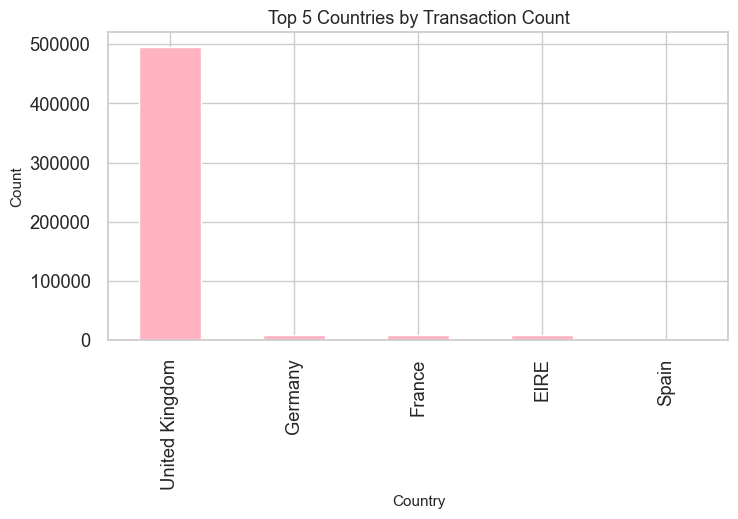

In [12]:
# Plot top 5 countries
plt.figure(figsize=(8, 4))
dataset['Country'].value_counts().head(5).plot(kind='bar')
plt.title('Top 5 Countries by Transaction Count')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

<div style="border-radius:20px; padding: 15px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">

**Description:**

The dataset contains 541,909 rows and 8 columns. Here is a brief overview of each column:

* InvoiceNo (object): Transaction identifier.
* StockCode (object): Product code.
* Description (object): Product description.
* Quantity (int64): Number of items purchased.
* InvoiceDate (object): Date and time of transaction.
* UnitPrice (float64): Price per unit(product price).
* CustomerID (float64): Customer identifier.
* Country (object): Country of the customer.

Numerical Columns:
* Quantity: Mean ~9.55, but ranges from -80,995 to 80,995, indicating possible returns or data errors.
* UnitPrice: Mean ~4.61, but ranges from -11,062.06 to 38,970, with negative values suggesting returns or cancellations.
* CustomerID: Missing values (non-null count < 541,909), needs handling.

Categorical Columns:
* Country: 38 unique values, most transactions originate from the United Kingdom.
* Description: 4,223 unique products, some missing values.
* InvoiceNo and StockCode: High cardinality, useful for grouping transactions.


Issues like missing CustomerID and Description, negative Quantity and UnitPrice, and outliers will need addressing in the cleaning step.
InvoiceDate is in string format and should be converted to datetime for temporal analysis.

<div style=" background-color: #ff4d6d; color:#ffffff; padding: 4px; border-radius: 15px; text-align: center; font-size: 110%; font-family: sans-serif">

## Step 3 | Dataset Cleaning

In [13]:
# Check all missing values percentage in the dataset.:

missing_data = dataset.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / dataset.shape[0]) * 100
print(f"Missing Values %:\n{missing_percentage} ")

Missing Values %:
Description    0.27
CustomerID    24.93
dtype: float64 


<div style="border-radius:20px; padding: 10px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">

By removing rows with missing values in the CustomerID and Description columns, we aim to construct a cleaner and more reliable dataset, which is essential for achieving accurate clustering and creating an effective recommendation system.
it's crucial to have accurate data on customer identifiers. Therefore, removing the rows with missing "CustomerIDs" maybe the best approach to maintain the integrity of the clusters and the analysis.

In [14]:
# Remove rows with missing values:

dataset = dataset.dropna(subset=["Description", "CustomerID"])

In [15]:
# Checking missing values after removing rows:

dataset.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [16]:
# Handling duplicated rows:

dataset[dataset.duplicated()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.00,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.00,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.00,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.00,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.00,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.00,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.00,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.00,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.00,United Kingdom


In [17]:
print(f"Duplicate rows: {dataset.duplicated().sum()}")

Duplicate rows: 5225


<div style="border-radius:20px; padding: 10px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">
    
Keeping these duplicate rows can introduce noise and potential inaccuracies in the clustering. 
By removing unnecessary duplicates, we ensure the accuracy of our analysis and optimize the performance of data processing.

In [18]:
# Remove duplicate rows:

dataset.drop_duplicates(inplace=True)

In [19]:
print(f"Duplicate rows after removing: {dataset.duplicated().sum()}")

Duplicate rows after removing: 0


In [20]:
# Find Cancellation orders in InvoiceNo that start with "C":

dataset[dataset['InvoiceNo'].astype(str).str.startswith('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.00,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.00,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.00,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.00,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.00,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.00,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.00,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.00,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.00,United Kingdom


In [21]:
dataset['Status'] = np.where(dataset['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

cancelled = dataset[dataset["Status"]=="Cancelled"]

In [22]:
cancelled.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,8872.00,-30.77,1172.25,-80995.00,-6.00,-2.00,-1.00,-1.00
UnitPrice,8872.00,18.90,445.19,0.01,1.45,2.95,4.95,38970.00
CustomerID,8872.00,14990.15,1708.23,12346.00,13505.00,14868.00,16393.00,18282.00


In [23]:
print(f"Percentage cancelled orders in dataset: { (cancelled.shape[0] / dataset.shape[0]) *100:.2f}")

Percentage cancelled orders in dataset: 2.21


In [24]:
# StockCode Analysis & Cleaning:

print(f"Number of StockCode(Product Code) unique values: {dataset['StockCode'].nunique()}")

Number of StockCode(Product Code) unique values: 3684


In [25]:
# view anomal StockCodes:

invalid_stock_codes = [c for c in dataset['StockCode'].unique() if sum(c.isdigit() for c in str(c)) in (0, 1)]

# Printing each stock code on a new line
print("Invalid stock codes:\n")
for code in invalid_stock_codes:
    print(code)

percentage_invalid = (dataset['StockCode'].isin(invalid_stock_codes).sum() / len(dataset)) * 100
print(f'\nPercentage of anomal Stock Codes: {percentage_invalid:.2f}%')

Invalid stock codes:

POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK

Percentage of anomal Stock Codes: 0.48%


In [26]:
# So lets remove anomal stock codes from whole dataset:
dataset = dataset[~dataset['StockCode'].isin(invalid_stock_codes)]

In [27]:
# Checking Stock Code after removing:

dataset["StockCode"].value_counts(normalize=True).head(10)*100

StockCode
85123A   0.52
22423    0.47
85099B   0.42
47566    0.35
84879    0.35
20725    0.34
22720    0.31
22197    0.28
23203    0.28
20727    0.27
Name: proportion, dtype: float64

In [28]:
# Treat UnitPrice invalid values:

dataset['UnitPrice'].describe()

count   399689.00
mean         2.91
std          4.45
min          0.00
25%          1.25
50%          1.95
75%          3.75
max        649.50
Name: UnitPrice, dtype: float64

In [29]:
dataset[dataset['UnitPrice'] == 0].describe()

,Quantity,UnitPrice,CustomerID
count,33.00,33.00,33.00
mean,420.52,0.00,14252.58
std,2176.71,0.00,1659.81
min,1.00,0.00,12415.00
25%,2.00,0.00,13081.00
50%,11.00,0.00,13985.00
75%,36.00,0.00,14911.00
max,12540.00,0.00,18059.00


In [30]:
# Remove UnitPrice with 0 value:

dataset = dataset[dataset['UnitPrice'] > 0]

In [31]:
# Remove rows with negative Quantity

dataset = dataset[dataset['Quantity'] > 0]

In [32]:
# Convert InvoiceDate to datetime

dataset['InvoiceDate'] = pd.to_datetime(dataset['InvoiceDate'])

In [33]:
dataset.drop(columns="Status", inplace=True)

In [34]:
dataset.shape

(391150, 8)

<div style="border-radius:20px; padding: 10px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">

**Cleaning Description:**
* Removed rows where CustomerID was missing, as it’s critical for customer segmentation.
* Filtered out rows with negative Quantity (likely returns or cancellations).
* Filtered out rows with negative or zero UnitPrice (likely errors or refunds).
* Checked and removed duplicate rows to prevent redundant data from affecting clustering.
* Excluding cancellations focuses the analysis on purchasing behavior, aligning with business goals like targeting active customers.
* Check and removed invalid StockCode rows.

After cleaning, the dataset shrank to 391,150 rows.

The dataset is now cleaner, with no missing CustomerID, no negative values, making it suitable for feature engineering.
The removal of ~26% of rows (due to missing CustomerID, negatives, duplicates and invalid values) is significant but necessary for reliable clustering.

<div style=" background-color: #ff4d6d; color:#ffffff; padding: 4px; border-radius: 15px; text-align: center; font-size: 110%; font-family: sans-serif">

## Step 4 | Feature Engineering

<div style="border-radius:20px; padding: 10px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">

**Create RFM and some other featuers**

Monetary: Total spending per customer, computed as Quantity * UnitPrice summed.
Engineered additional features like ProductDiversity (unique StockCode counts per customer) and AvgOrderValue.

RFM is a method used for analyzing customer value and segmenting the customer.RFM help in understanding a customer's buying behavior, which is crucial in personalizing marketing strategies and creating a recommendation system.

* Recency (R): Days since the last purchase, calculated from the most recent InvoiceDate. Lower recency value indicates the customer has purchased recently.

* Frequency (F): Number of transactions per customer, derived from InvoiceNo counts.(how often a customer makes a purchase within a specific time period). A higher value indicates a customer with higher loyalty or satisfaction.

* Monetary (M): The total spending a customer in certain period, computed as Quantity * UnitPrice summed. Customers with higher monetary value have contributed more to the business.

* Engineered additional features like ProductDiversity, TotalPurchasedProduct, AvgOrderValue, AvgDaysBetweenPurchases, tenureDays, MonthlySpendingMean


In [35]:
dataset['InvoiceDay'] = dataset['InvoiceDate'].dt.date # Get date in correct format then convert it
reference_date = dataset['InvoiceDay'].max()  + pd.Timedelta(days=1)
reference_date = pd.to_datetime(reference_date)

# Create TotalPrice feature
dataset['TotalPrice'] = dataset['Quantity'] * dataset['UnitPrice']

# Group by CustomerID to calculate RFM and other features
customer_data = dataset.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Last Purchase(Recency)
    'InvoiceNo': 'nunique',                                   # Total Transactions(Frequency)
    'TotalPrice': 'sum',                                      # Total Spend(Monetary)
    'StockCode': 'nunique',                                 # Unique Product Purchased(Product Diversity)
    "Quantity": 'sum',                                        # Total Product Purchased by Each Customer
}).reset_index()

# Rename columns for clarity
customer_data.columns = ['CustomerID', 'LastPurchaseDays', 'TotalTransaction', 'TotalSpend','ProductDiversity', "TotalPurchasedProduct"]

In [36]:
# Add Average Order Value Feature:

aov = dataset.groupby('CustomerID')['TotalPrice'].mean().reset_index()
total_price = dataset.groupby('CustomerID')['TotalPrice'].sum().reset_index()

if "AvgOrderValue" in customer_data.columns:
    pass
else:
    customer_data = pd.merge(customer_data, aov, on="CustomerID")
    
customer_data.rename(columns={'TotalPrice': "AvgOrderValue"}, inplace=True)

In [37]:
# Adding the average number of days between consecutive purchases feature:

dataset['TimeDiff'] = dataset.groupby('CustomerID')['InvoiceDate'].diff().dt.days
time_between = dataset.groupby('CustomerID')['TimeDiff'].mean().reset_index().fillna(0)

if "AvgDaysBetweenPurchases" in customer_data.columns:
    pass
else:
    customer_data = pd.merge(customer_data, time_between, on="CustomerID")

customer_data.rename(columns={'TimeDiff': "AvgDaysBetweenPurchases"}, inplace=True)

dataset.drop(columns=['TimeDiff'], inplace=True)

In [38]:
# Customer Tenure
tenure = dataset.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max']).reset_index()
tenure['TenureDays'] = (tenure['max'] - tenure['min']).dt.days
tenure = tenure[['TenureDays', 'CustomerID']]
if "TenureDays" in customer_data.columns:
    pass
else:
    customer_data = pd.merge(customer_data, tenure, on="CustomerID")

In [39]:
# Extract year and month from InvoiceDate
dataset['Year'] = dataset['InvoiceDate'].dt.year
dataset['Month'] = dataset['InvoiceDate'].dt.month

# Group by CustomerID and YearMonth to get monthly spending
monthly_spending = dataset.groupby(['CustomerID', 'Year', 'Month'])['TotalPrice'].sum().reset_index()

# Calculate mean monthly spending per customer
monthly_spending = monthly_spending.groupby('CustomerID')['TotalPrice'].mean().reset_index()
monthly_spending.columns = ['CustomerID', 'MonthlySpendingMean']

if "MonthlySpendingMean" in customer_data.columns:
    pass
else:
    customer_data = pd.merge(customer_data, monthly_spending, on="CustomerID")
    
dataset.drop(columns=['Year', 'Month'], inplace=True)

In [40]:
customer_data.head()

,CustomerID,LastPurchaseDays,TotalTransaction,TotalSpend,ProductDiversity,TotalPurchasedProduct,AvgOrderValue,AvgDaysBetweenPurchases,TenureDays,MonthlySpendingMean
0,12346.00,325,1,77183.60,1,74215,77183.60,0.00,0,77183.60
1,12347.00,2,7,4310.00,103,2458,23.68,2.00,365,615.71
2,12348.00,75,4,1437.24,21,2332,53.23,10.85,282,359.31
3,12349.00,18,1,1457.55,72,630,20.24,0.00,0,1457.55
4,12350.00,310,1,294.40,16,196,18.40,0.00,0,294.40


In [41]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4334 entries, 0 to 4333
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               4334 non-null   float64
 1   LastPurchaseDays         4334 non-null   int64  
 2   TotalTransaction         4334 non-null   int64  
 3   TotalSpend               4334 non-null   float64
 4   ProductDiversity         4334 non-null   int64  
 5   TotalPurchasedProduct    4334 non-null   int64  
 6   AvgOrderValue            4334 non-null   float64
 7   AvgDaysBetweenPurchases  4334 non-null   float64
 8   TenureDays               4334 non-null   int64  
 9   MonthlySpendingMean      4334 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 338.7 KB


<div style="border-radius:20px; padding: 10px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">

**Customer Data featuers description:**

* CustomerID: _Identifier number uniquely assigned to each customer._
* LastPurchaseDays: _The number of days since customer's last purchase._
* TotalTransaction: _The total number of transactions made by a customer._
* TotalSpend: _The total spending the customer has made across all transactions._
* ProductDiversity: _Number of different product per customer across transactions_
* TotalPurchasedProduct: _The total quantity of products purchased by the customer among all transactions._
* AvgOrderValue: _Average order value per customer among transactions_
* AvgDaysBetweenPurchases: _The average days between consecutive purchases made by customer._
* TenureDays: _Shows how new a customer._
* MonthlySpendingMean: _The customer average monthly spending._

<div style=" background-color: #ff4d6d; color:#ffffff; padding: 4px; border-radius: 15px; text-align: center; font-size: 110%; font-family: sans-serif">

## Step 5 | Data Visualization

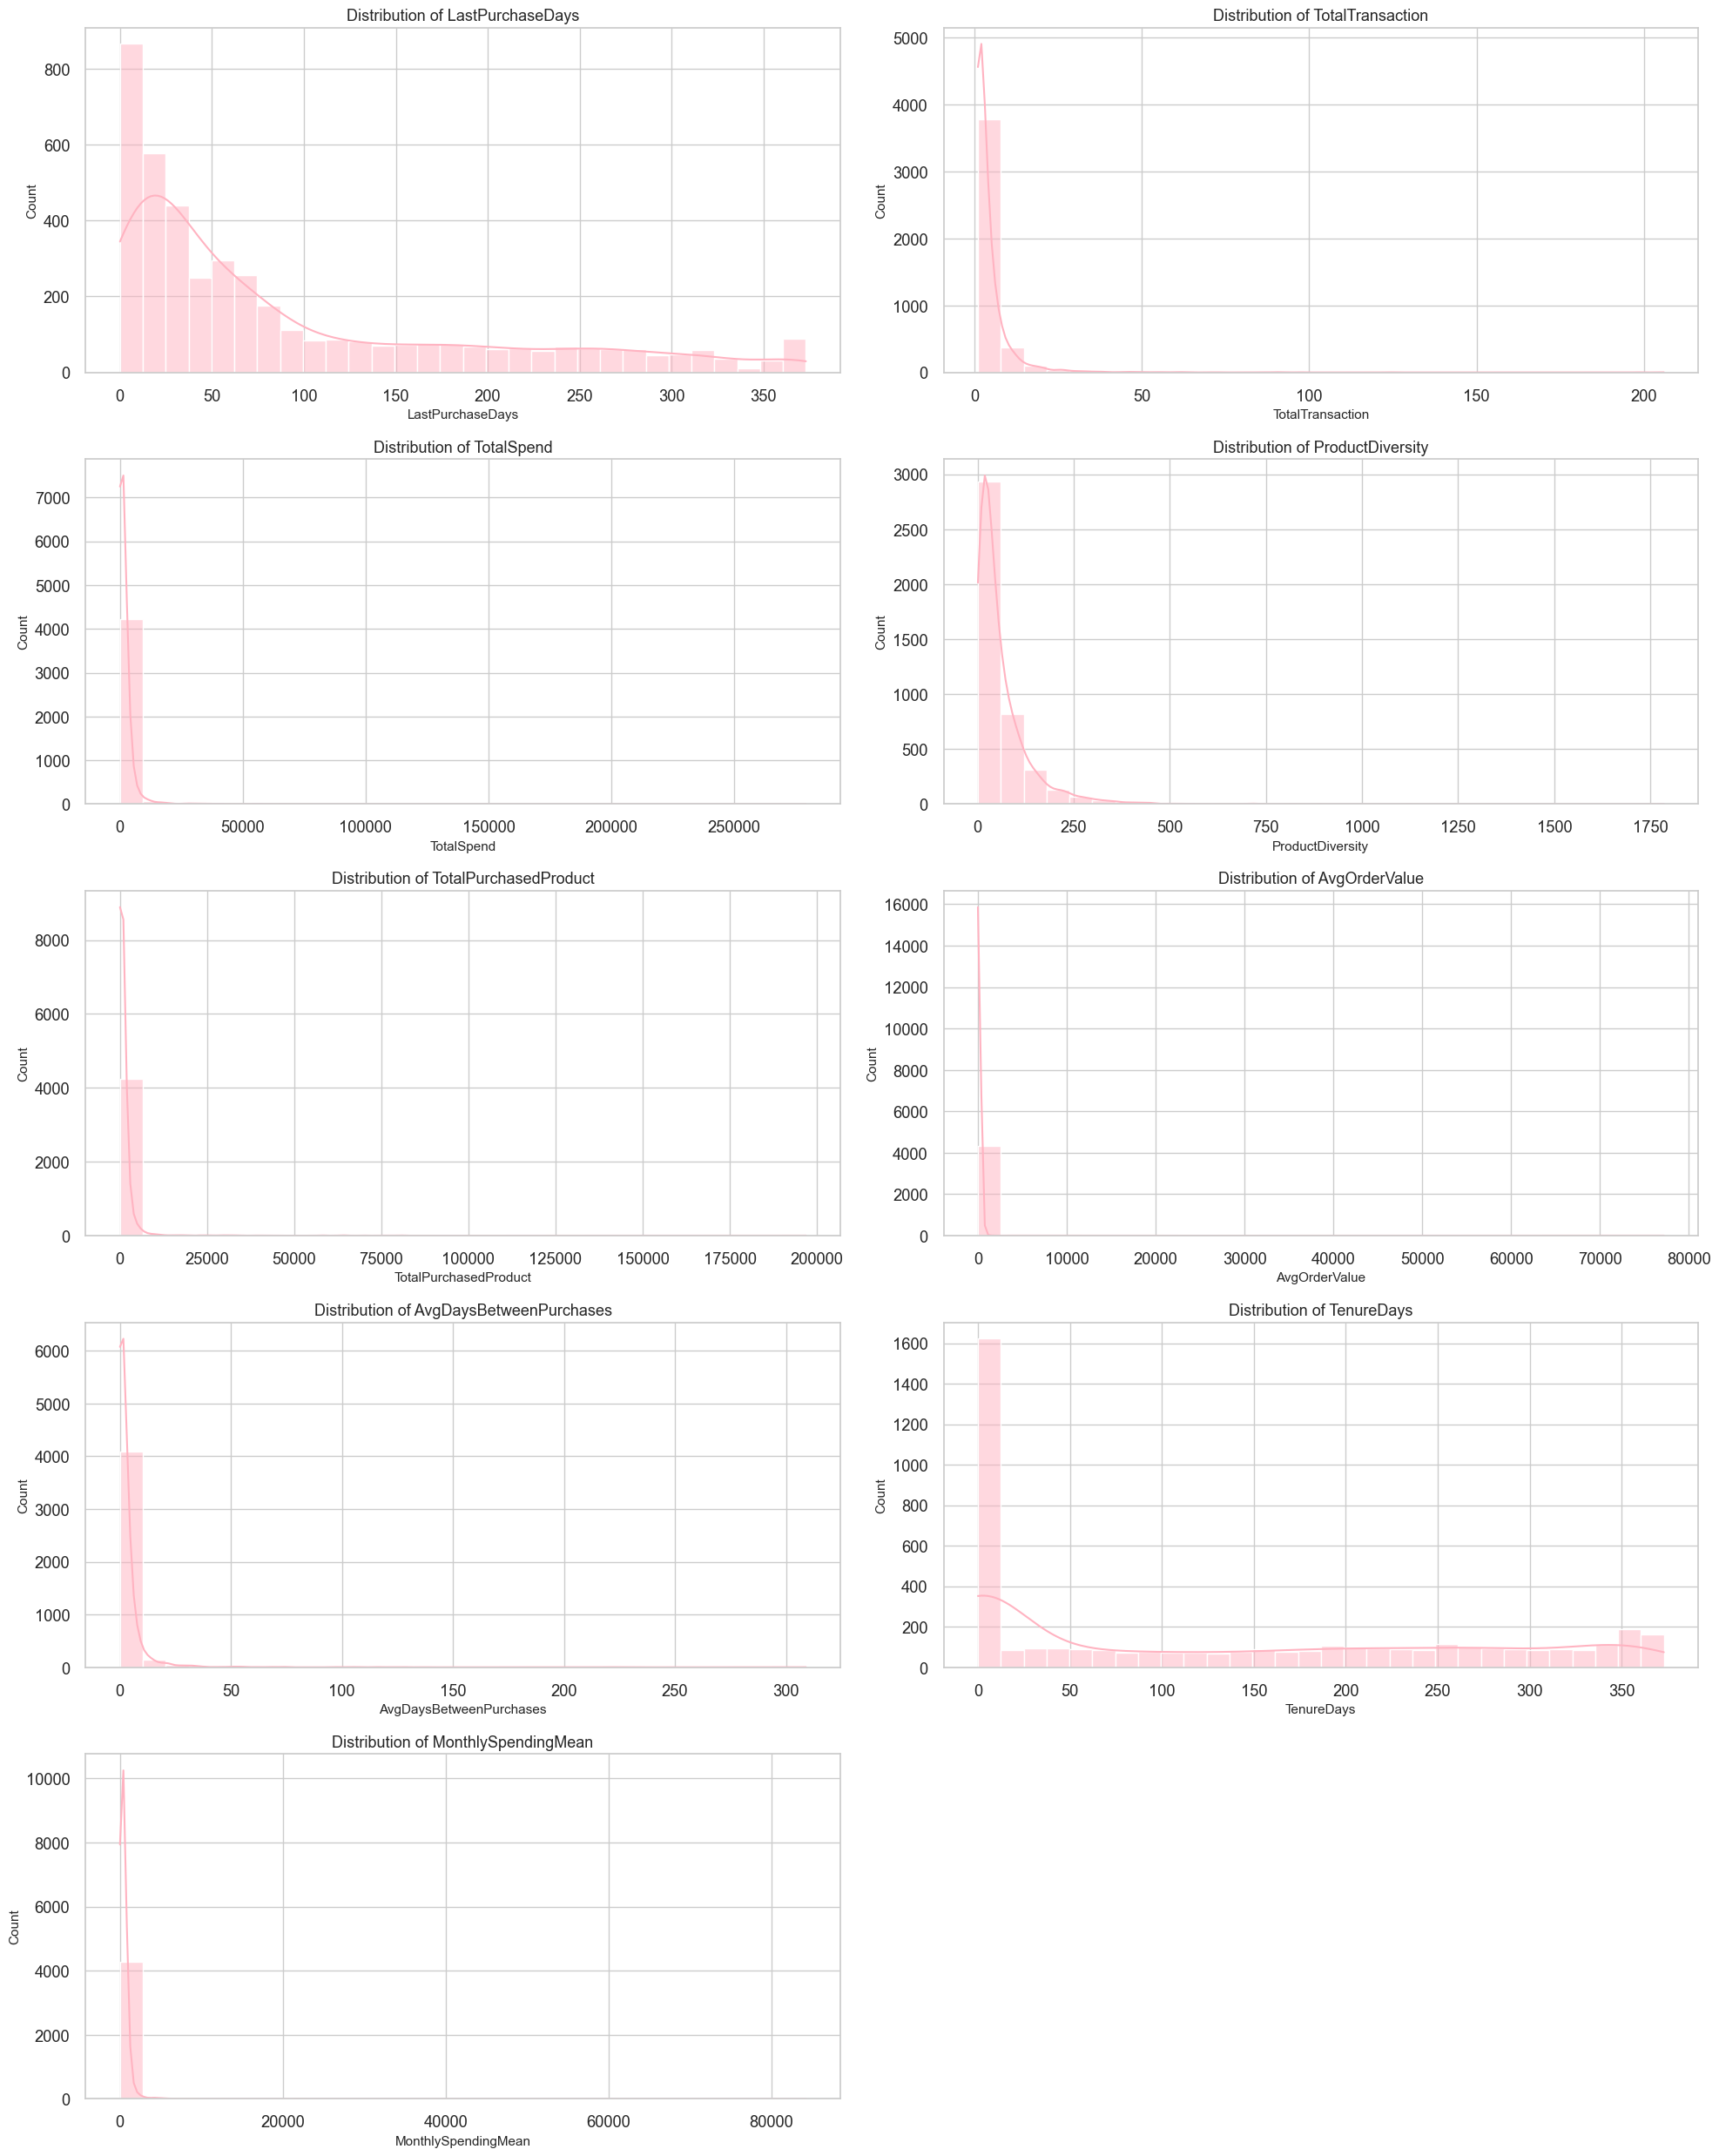

In [42]:
column_name = customer_data.columns.drop("CustomerID").values

plt.figure(figsize=(20, 25))
for i, column in enumerate(column_name, 1):
    plt.subplot(5, 2, i)
    sns.histplot(customer_data[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

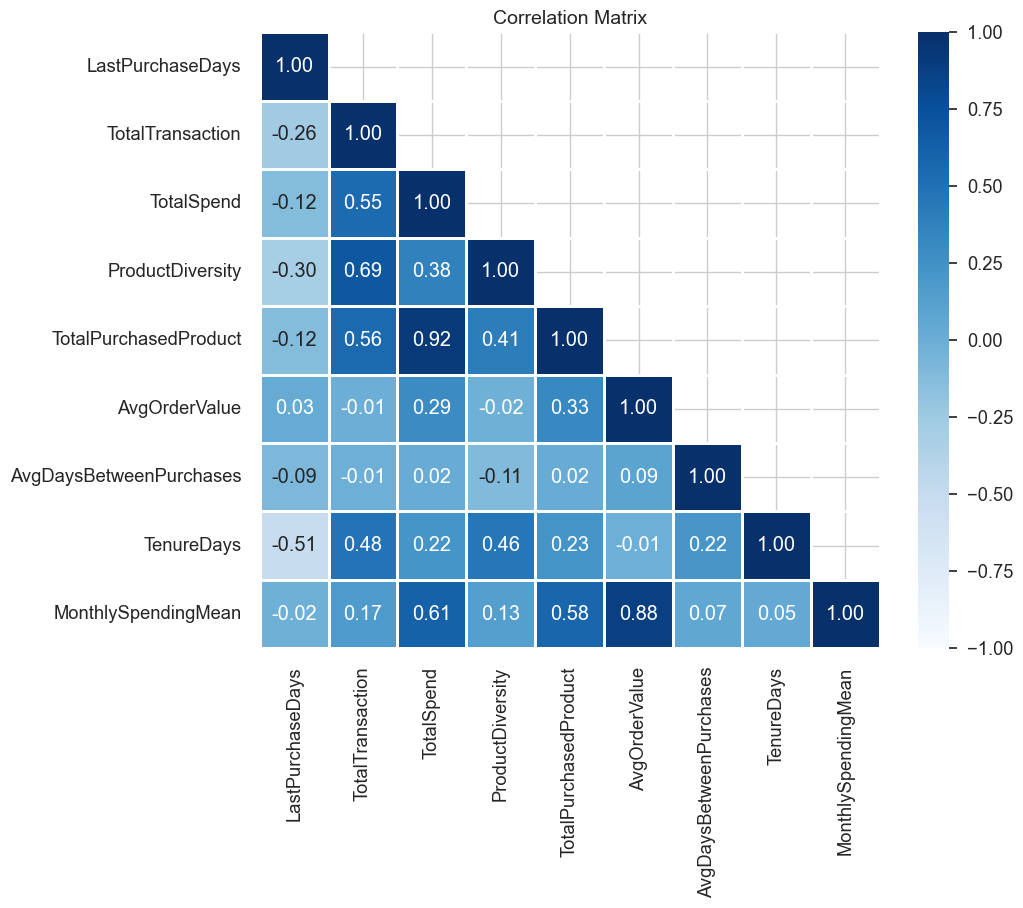

In [43]:
# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data.drop(columns=['CustomerID']).corr()

# Create a mask to only show the lower triangle of the matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="Blues",mask=mask, annot=True, center=0,vmin=-1, vmax=1, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

<div style="border-radius:20px; padding: 10px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">
    
We can see that there are some pairs of variables that have high correlations, for instance:
    
* AvgOrderValue vs MonthlySpendingMean
* TotalSpend vs TotalPurchasedProduct

These high correlations indicate that these variables move closely together, implying a degree of multicollinearity.

We'll treat this multicollinearity through dimensionality reduction techniques such as PCA to create a set of uncorrelated variables. This will help in achieving more stable clusters during the KMeans clustering process.

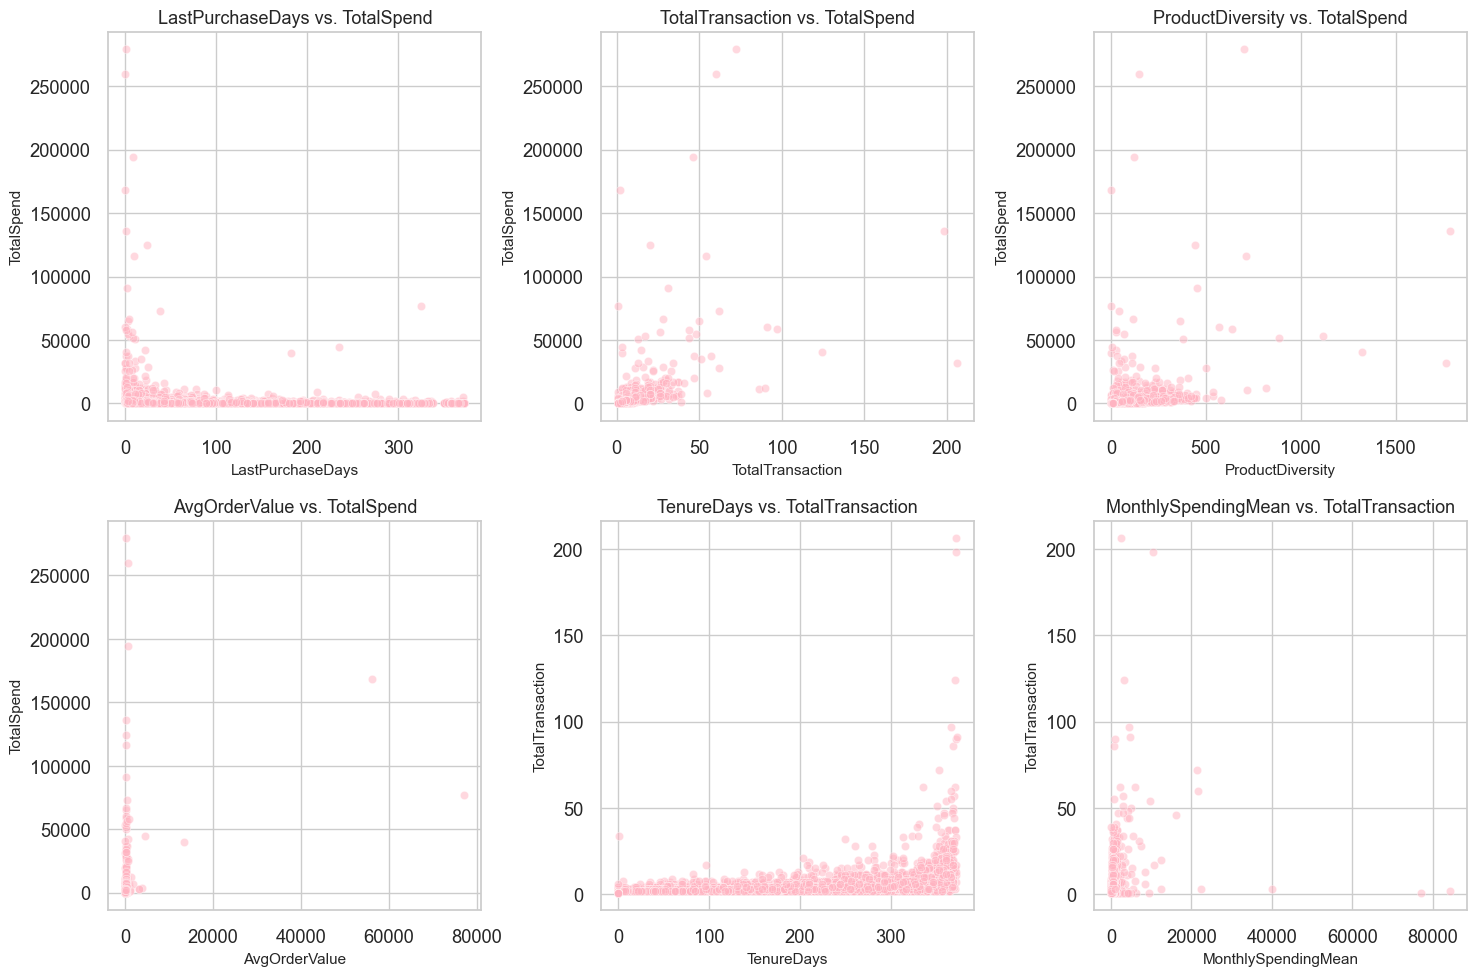

In [44]:
# Scatter plots for key pairs

key_pairs = [
    ('LastPurchaseDays', 'TotalSpend'),
    ('TotalTransaction', 'TotalSpend'),
    ('ProductDiversity', 'TotalSpend'),
    ('AvgOrderValue', 'TotalSpend'),
    ('TenureDays', 'TotalTransaction'),
    ('MonthlySpendingMean', 'TotalTransaction')
]
plt.figure(figsize=(15, 10))
for i, (x, y) in enumerate(key_pairs, 1):
    plt.subplot(2, 3, i)
    sns.scatterplot(data=customer_data, x=x, y=y, alpha=0.5)
    plt.title(f'{x} vs. {y}')
    plt.xlabel(x)
    plt.ylabel(y)
plt.tight_layout()
plt.show()

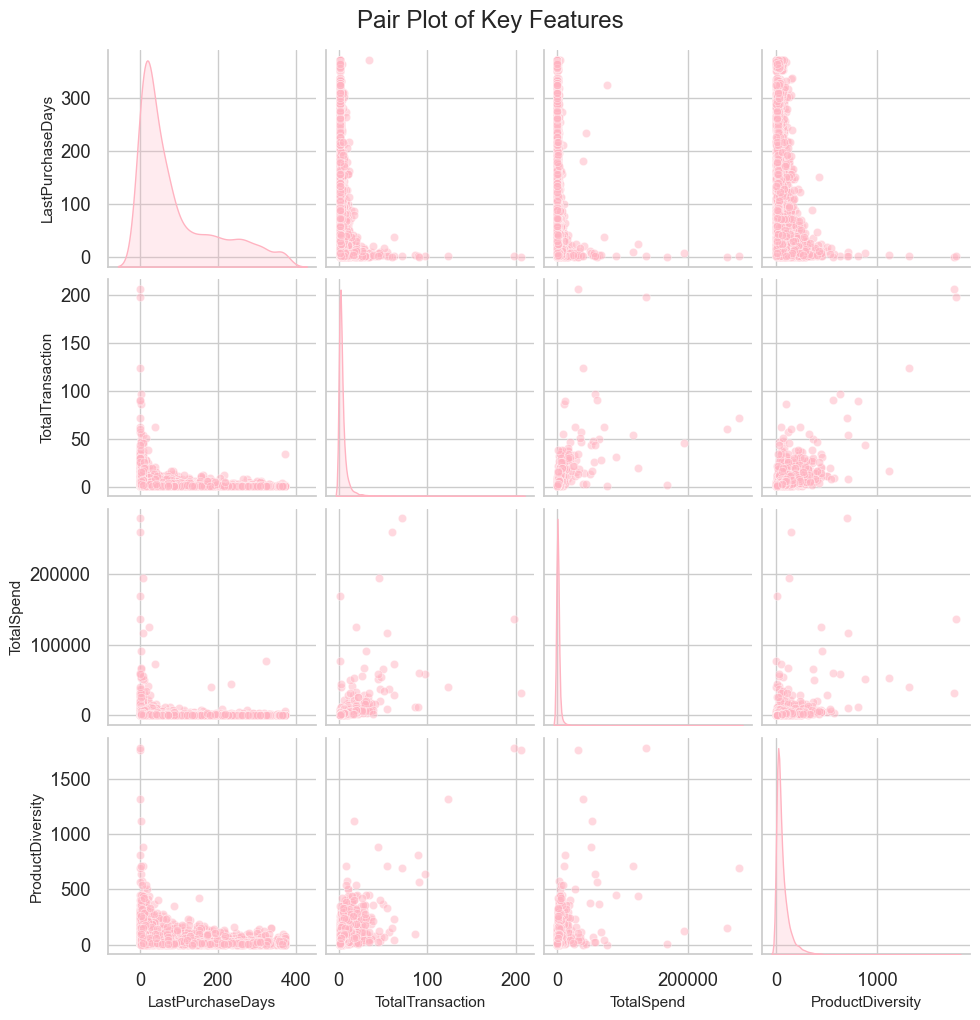

In [45]:
subset_features = ['LastPurchaseDays', 'TotalTransaction', 'TotalSpend', 'ProductDiversity']
sns.pairplot(customer_data[subset_features], diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pair Plot of Key Features', y=1.02)
plt.show()

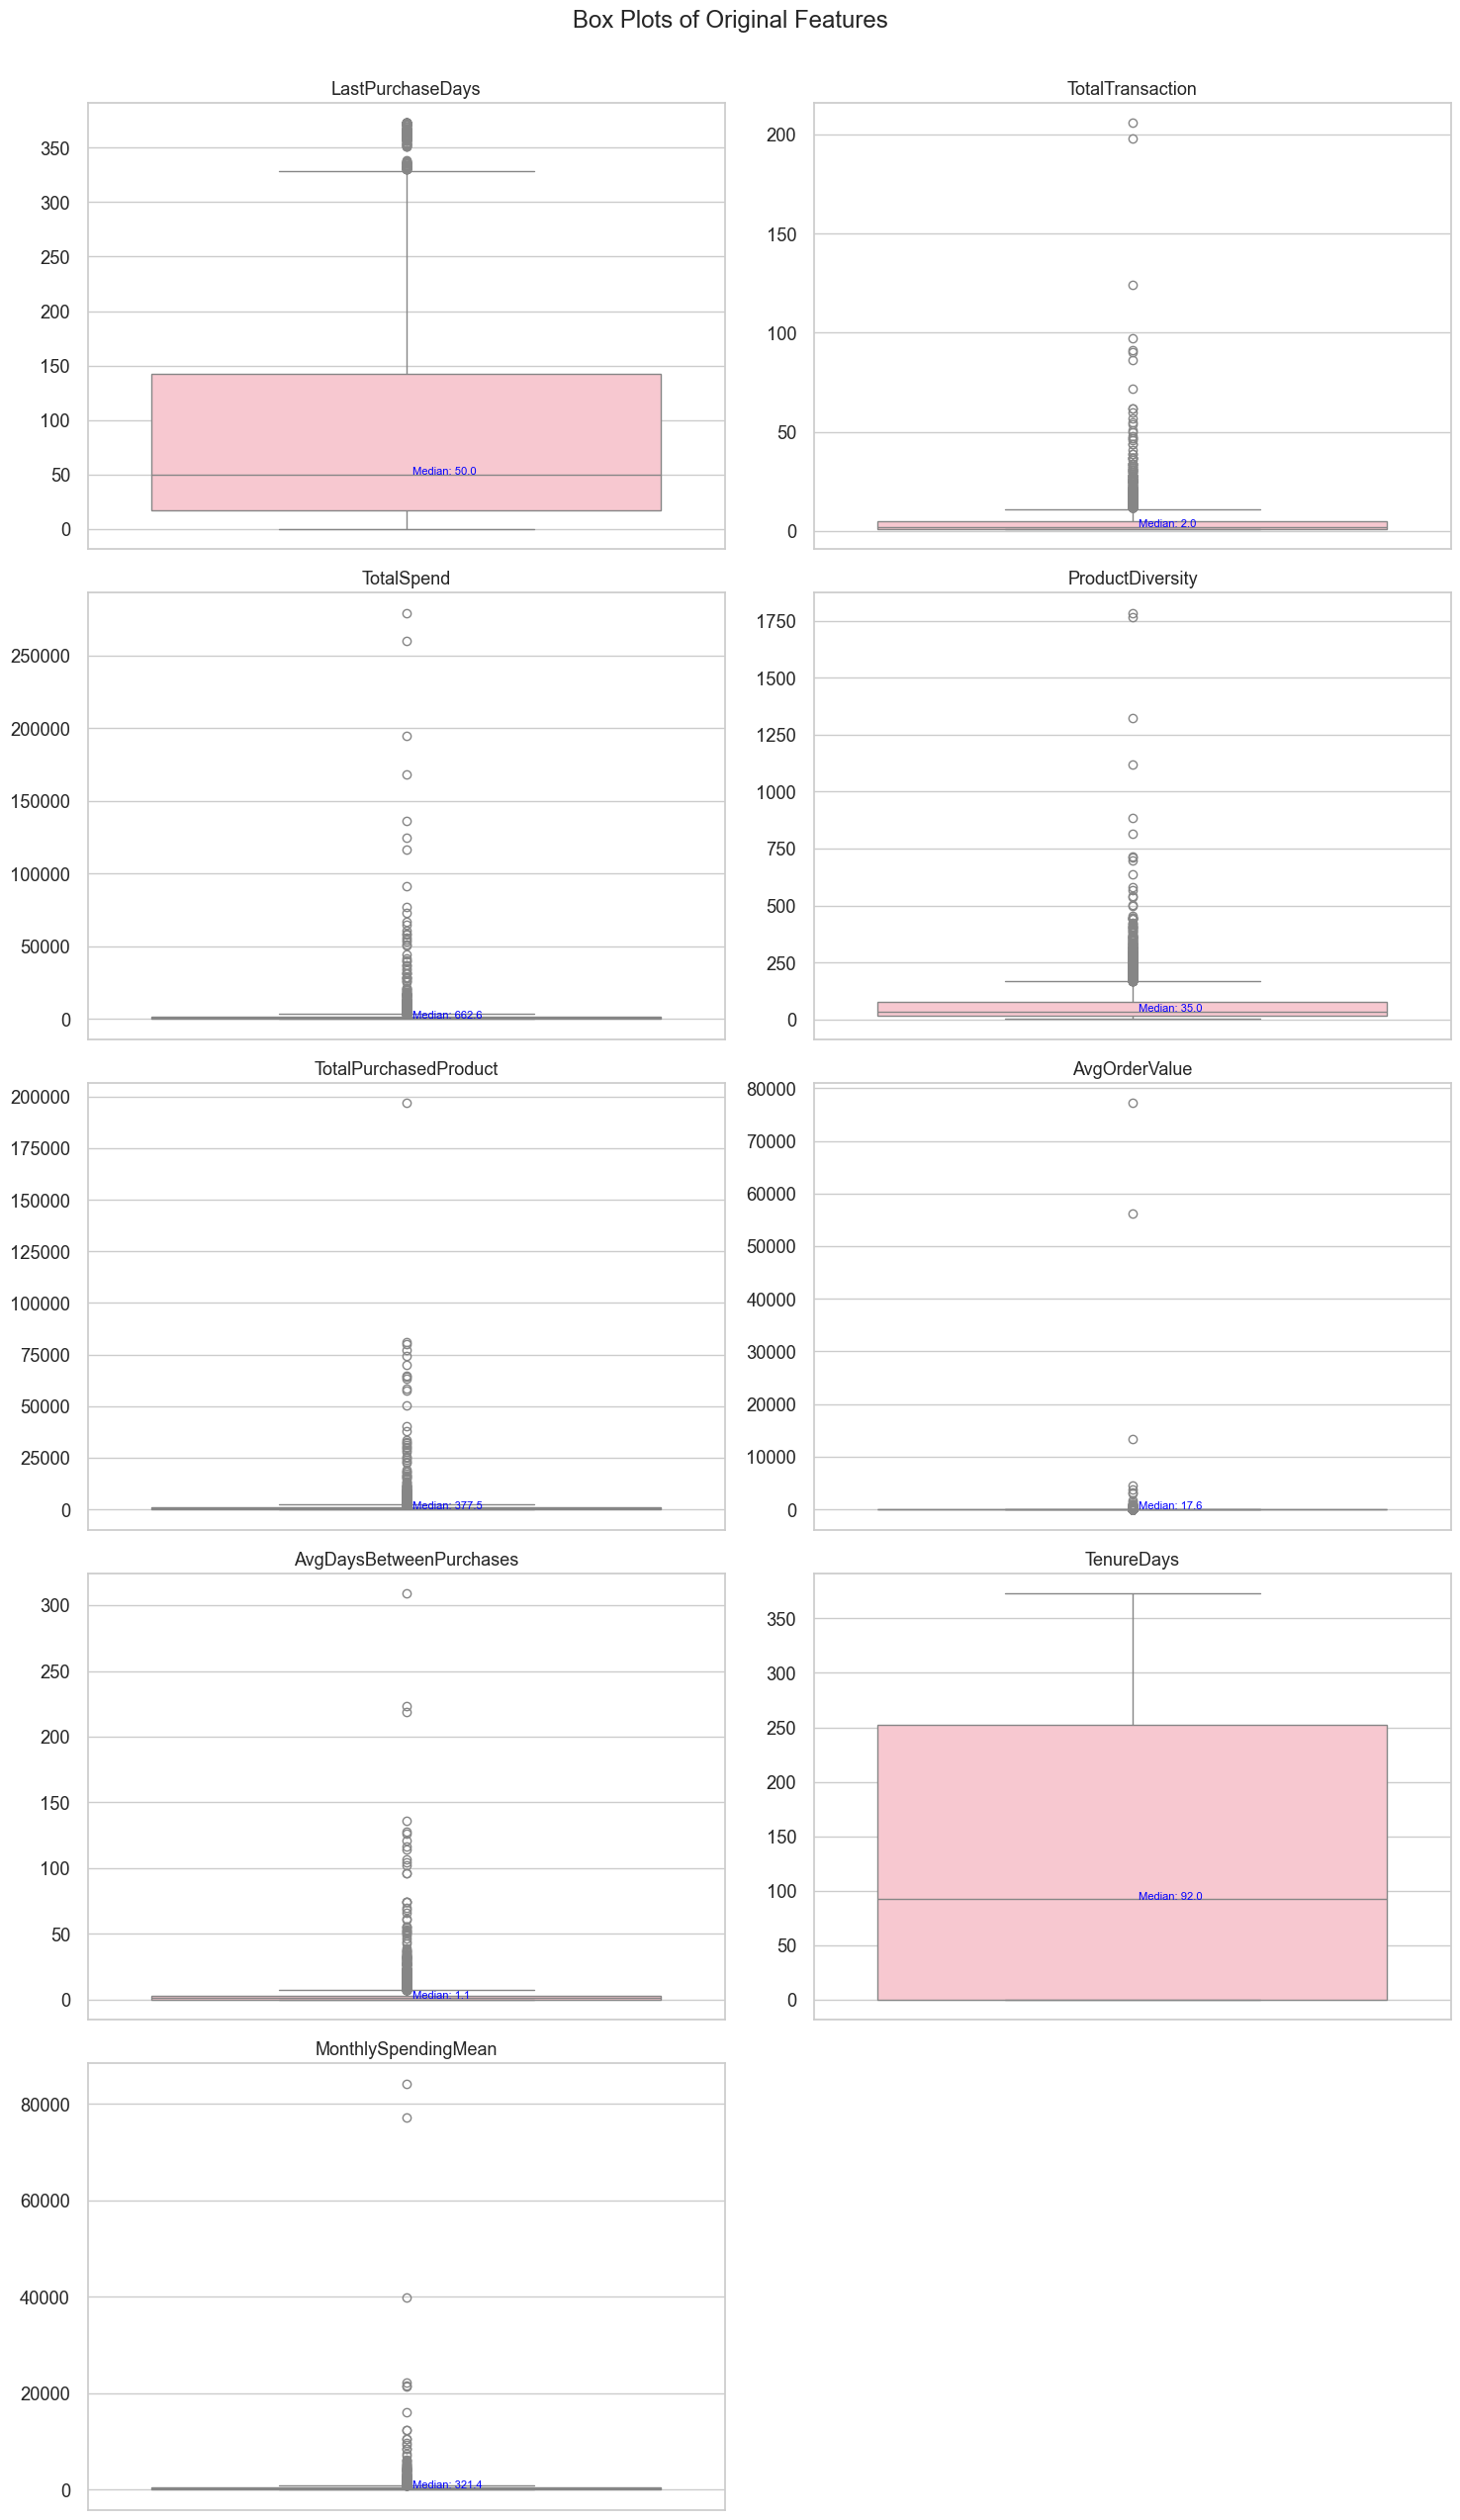

In [46]:
plt.figure(figsize=(15, 25))
for i, feature in enumerate(column_name, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(y=customer_data[feature], color='pink')
    plt.title(f'{feature}')
    plt.ylabel('')
    # Add median annotation
    median = customer_data[feature].median()    
    plt.text(0.01, median, f'Median: {median:.1f}', color='blue', fontsize=8)
plt.tight_layout()
plt.suptitle('Box Plots of Original Features', y=1.02)
plt.show()

<div style=" background-color: #ff4d6d; color:#ffffff; padding: 4px; border-radius: 15px; text-align: center; font-size: 110%; font-family: sans-serif">

## Step 6 | Data Preprocessing

<div style=" background-color: #ff8fa3; color:#ffffff; padding: 4px; border-radius: 0px 0px 30px 30px; text-align: center; font-size: 110%; font-family: sans-serif; width: 60%">

### Step 6-1 | Outliers Treatement

In [47]:
# We used Isolation Forest method, also we could used IQR method too.

In [48]:
# Initializing the IsolationForest model with a contamination parameter of 0.1

model = IsolationForest(contamination=0.1, random_state=42)

# Fitting the model on our dataset
customer_data['IsOutliers'] = model.fit_predict(customer_data.iloc[:, 1:])

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Outlier'] = [1 if outlier == -1 else 0 for outlier in customer_data['IsOutliers']]


In [49]:
# Data shape before removing outliers:

customer_data.shape

(4334, 12)

In [50]:
# We'll separate the outliers from original data for later analysis:
outliers_data = customer_data[customer_data['Outlier'] == 1]

# Remove outliers data from dataset
customer_data = customer_data[customer_data['Outlier'] == 0]

# Drop the 'OutlierScore' and 'Outlier' columns
customer_data = customer_data.drop(columns=['IsOutliers', 'Outlier']).reset_index(drop=True)

In [51]:
# Data shape after removing outliers:

customer_data.shape

(3900, 10)

In [52]:
outliers_data.shape

(434, 12)

In [53]:
customer_data.head()

,CustomerID,LastPurchaseDays,TotalTransaction,TotalSpend,ProductDiversity,TotalPurchasedProduct,AvgOrderValue,AvgDaysBetweenPurchases,TenureDays,MonthlySpendingMean
0,12347.00,2,7,4310.00,103,2458,23.68,2.00,365,615.71
1,12348.00,75,4,1437.24,21,2332,53.23,10.85,282,359.31
2,12349.00,18,1,1457.55,72,630,20.24,0.00,0,1457.55
3,12350.00,310,1,294.40,16,196,18.40,0.00,0,294.40
4,12352.00,36,7,1385.74,57,526,18.00,3.39,260,346.44


<div style=" background-color: #ff8fa3; color:#ffffff; padding: 4px; border-radius: 0px 0px 30px 30px; text-align: center; font-size: 110%; font-family: sans-serif; width: 60%">

### Step 6-2 | Features Scaling

In [54]:
# Scale dataset using Standard Scaler

scaler = StandardScaler()
scaleable_columns = customer_data.drop("CustomerID", axis=1).columns
scaled_customer_data = customer_data.copy()
scaled_customer_data[scaleable_columns] = scaler.fit_transform(scaled_customer_data[scaleable_columns])

In [55]:
scaled_customer_data.describe()

,CustomerID,LastPurchaseDays,TotalTransaction,TotalSpend,ProductDiversity,TotalPurchasedProduct,AvgOrderValue,AvgDaysBetweenPurchases,TenureDays,MonthlySpendingMean
count,3900.00,3900.00,3900.00,3900.00,3900.00,3900.00,3900.00,3900.00,3900.00,3900.00
mean,15301.94,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00
std,1714.22,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,12347.00,-0.95,-0.75,-0.92,-1.00,-0.87,-0.79,-0.64,-0.93,-1.43
25%,13823.75,-0.76,-0.75,-0.66,-0.70,-0.65,-0.40,-0.64,-0.93,-0.69
50%,15300.50,-0.42,-0.40,-0.37,-0.35,-0.38,-0.19,-0.33,-0.38,-0.21
75%,16773.25,0.55,0.31,0.30,0.36,0.28,0.03,0.19,0.88,0.38
max,18287.00,2.77,7.72,5.49,5.57,9.82,16.52,7.17,2.02,6.65


<div style=" background-color: #ff8fa3; color:#ffffff; padding: 4px; border-radius: 0px 0px 30px 30px; text-align: center; font-size: 110%; font-family: sans-serif; width: 60%">

### Step 6-3 | Dimensionality Reduction using PCA

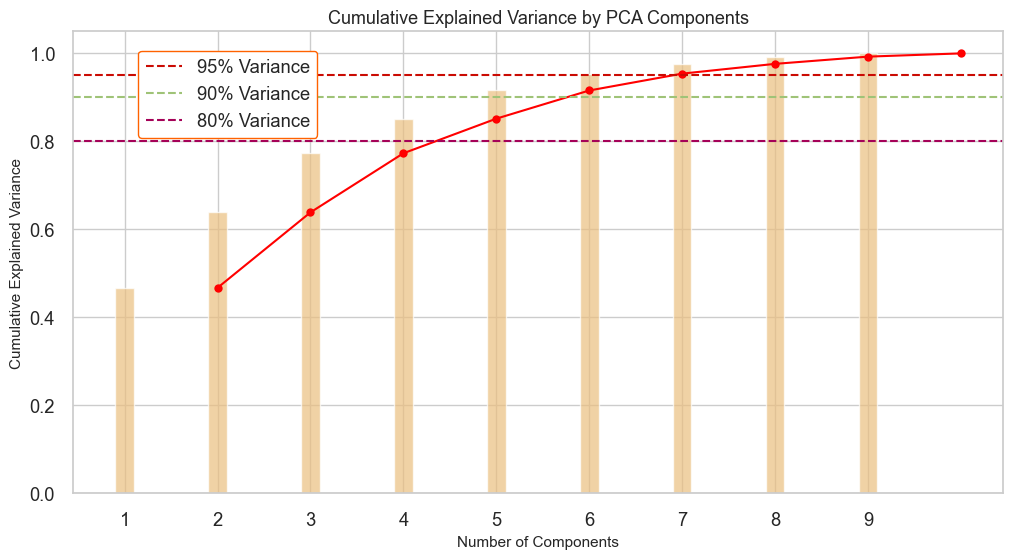

In [56]:
scaled_customer_data.set_index('CustomerID', inplace=True)
pca = PCA()
pca.fit(scaled_customer_data)

# Calculate cumulative explained and cumsum variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot
# Set seaborn plot style
# sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')
plt.figure(figsize=(12, 6))
sns.barplot(x=list(range(1, len(cumulative_variance) + 1)), y=cumulative_variance, color='#fcc36d', alpha=0.7, width=0.2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='red')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Variance')
plt.axhline(y=0.80, color='m', linestyle='--', label='80% Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend(
           loc=(0.07, 0.77),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200') 
plt.grid(True)
plt.show()

<div style="border-radius:20px; padding: 10px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">

**Choosing The Number Of Components For PCA:**

The choice of 6 components was informed by an analysis of the explained variance ratio. To determine the optimal number of components, I first applied PCA without specifying the number of components, fitting it to the scaled dataset. I then extracted the explained variance ratio, a measure of how much of the total variance in the data each component captures. Plotting this ratio using Matplotlib revealed a cumulative variance curve, showing that the first 6 components accounted for over 90% of the total variance.

<div style="border-radius:20px; padding: 10px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">

The goal of this step was to transform the raw data into a format that would allow the K-Means clustering algorithm to effectively group customers based on their purchasing behavior. This involved addressing two critical challenges: ensuring all features contribute equally to the clustering process and simplifying the dataset to enhance computational efficiency and interpretability. To achieve this, I implemented feature scaling and dimensionality reduction, two techniques that are foundational to successful clustering in a dataset with diverse and potentially correlated features.

The features varied widely in their scales and distributions. For example, Monetary values ranged from a few pounds to thousands, while Frequency typically spanned from 1 to 100, and Recency was measured in days up to 373. Such differences in magnitude and units posed a problem for K-Means, a distance-based clustering algorithm that calculates the similarity between customers using Euclidean distances. Without preprocessing, features with larger ranges, like Monetary, would disproportionately influence the distance calculations, skewing the resulting clusters and undermining the goal of identifying meaningful customer segments.

* **Outlier Treatment:** We applied Isolation Forest to flag customers with extreme purchasing patterns. Once identified, these outliers were removed(and saved in seperated dataset for later uses) from the dataset.We chose the amount of contamination(0.1) through tests and reviews that we think is the best amount.

* **Features Scaling:** This transformation ensured that all features, regardless of their original units or ranges, were now on the same scale, allowing K-Means to treat them equally when measuring customer similarity.

* **PCA:** This produced a new dataset where each customer was represented by 6 principal component scores instead of the original features. Each principal component is a linear combination of the original features, weighted by their contribution to the variance along that component’s direction.PCA was executed by fitting it to the scaled dataset, analyzing the explained variance ratio to select 6 components, and transforming the data into a lower-dimensional representation.

In [57]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
pca_customer_data = pca.fit_transform(scaled_customer_data)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
pca_customer_data = pd.DataFrame(pca_customer_data, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
pca_customer_data.index = customer_data.index

In [58]:
# Displaying the resulting dataframe based on the PCs
pca_customer_data.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6
0,4.78,-0.52,0.50,0.43,-0.01,-0.76
1,1.91,1.85,2.10,0.55,0.79,-0.70
2,0.89,-2.97,1.15,-2.54,1.82,-0.10
3,-2.20,-0.95,-0.12,1.31,0.56,-0.06
4,1.35,0.96,-0.18,0.18,-0.33,-0.12


In [59]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def loadings(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=scaled_customer_data.columns)

pc_df.style.apply(loadings, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
LastPurchaseDays,-0.277721,-0.245664,0.040051,0.820169,0.416261,0.114417
TotalTransaction,0.414218,0.134893,-0.046309,0.358099,-0.314098,-0.220843
TotalSpend,0.452738,-0.167147,0.118315,0.144464,0.030570,-0.223766
ProductDiversity,0.378803,-0.182323,-0.311174,-0.014332,0.014338,0.777977
TotalPurchasedProduct,0.432206,-0.167708,0.088393,0.137071,0.004424,-0.327432
AvgOrderValue,-0.032672,-0.015347,0.841671,0.095015,-0.394228,0.350841
AvgDaysBetweenPurchases,0.084095,0.671552,0.258184,-0.039800,0.532956,0.016906
TenureDays,0.390311,0.384253,-0.032983,0.133099,0.110646,0.226589
MonthlySpendingMean,0.235684,-0.482989,0.318518,-0.361798,0.524604,-0.029792


In [60]:
# For each PCA component, find the top 3 most influential features
for pc in pc_df.columns:
    top_features = pc_df[pc].abs().nlargest(3).index
    print(f"{pc} is most influenced by: {', '.join(top_features)}")

PC1 is most influenced by: TotalSpend, TotalPurchasedProduct, TotalTransaction
PC2 is most influenced by: AvgDaysBetweenPurchases, MonthlySpendingMean, TenureDays
PC3 is most influenced by: AvgOrderValue, MonthlySpendingMean, ProductDiversity
PC4 is most influenced by: LastPurchaseDays, MonthlySpendingMean, TotalTransaction
PC5 is most influenced by: AvgDaysBetweenPurchases, MonthlySpendingMean, LastPurchaseDays
PC6 is most influenced by: ProductDiversity, AvgOrderValue, TotalPurchasedProduct


<div style="border-radius:20px; padding: 10px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">

<h2>PCA Loadings Analysis:</h2>

The PCA loadings indicate how each original feature contributes to the principal components, which were used to define the clusters. Here’s a breakdown of the key components driving the separation:

* PC1 captures overall customer activity and value. Higher PC1 values indicate more active, higher-spending customers who purchase frequently and have longer tenure.
  - Positive Correlations: TotalSpend (0.45), TotalPurchasedProduct (0.43), TotalTransaction (0.41), ProductDiversity (0.38), TenureDays (0.39).
  - Negative Correlation: LastPurchaseDays (-0.28).

* PC2 : Reflects purchase frequency and longevity. Higher PC2 values suggest customers with longer tenure but less frequent purchases or lower monthly spending.
  - Positive Correlations: AvgDaysBetweenPurchases (0.67), TenureDays (0.38).
  - Negative Correlation: MonthlySpendingMean (-0.48).

* PC3 : Distinguishes customers based on their average spend per transaction.
  - Positive Correlation: AvgOrderValue (0.84).

Other Components:
* PC4: Strong loading for LastPurchaseDays (0.82) → captures recency.
* PC5: Mixed loadings with AvgDaysBetweenPurchases (0.53) and MonthlySpendingMean (0.52).
* PC6: High loading for ProductDiversity (0.78) → focuses on purchase variety.
These components collectively reduce the dimensionality of your data while preserving key patterns, allowing the K-Means algorithm to group customers into meaningful clusters.

<div style=" background-color: #ff4d6d; color:#ffffff; padding: 4px; border-radius: 15px; text-align: center; font-size: 110%; font-family: sans-serif">

## Step 7 | Model Building

<div style=" background-color: #ff8fa3; color:#ffffff; padding: 4px; border-radius: 0px 0px 30px 30px; text-align: center; font-size: 110%; font-family: sans-serif; width: 60%">

### Step 7-1 | Find Optimal K of Clusters

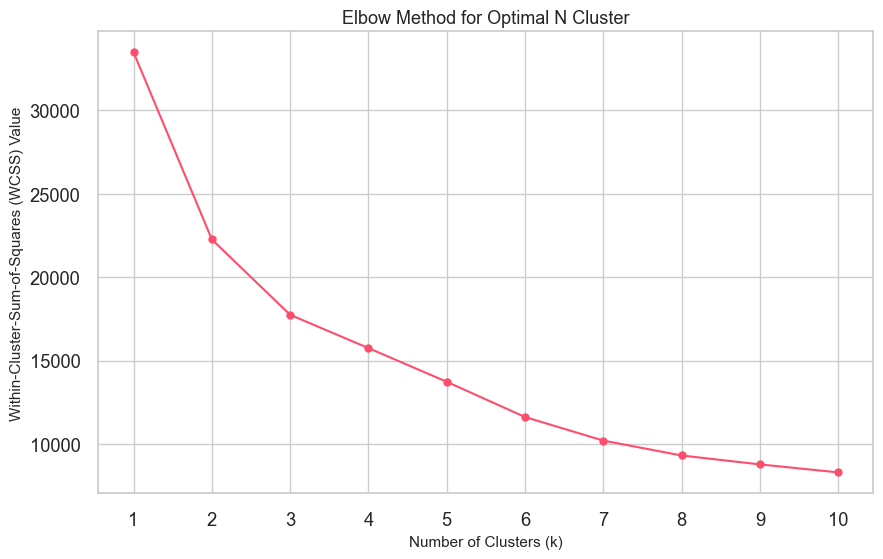

In [61]:
# Implement Elbow Method to Find Optimal Number of Clusters

wcss = []
k_range = range(1,11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, max_iter=200)
    kmeans.fit(pca_customer_data)
    wcss.append(kmeans.inertia_)

#Visual the Elbow Methord to Select Best Number of Cluster:
plt.plot(k_range, wcss, marker='o', color='#ff4d6d')
plt.xlabel("Number of Clusters (k)")
plt.xticks(k_range)
plt.ylabel("Within-Cluster-Sum-of-Squares (WCSS) Value")
plt.title("Elbow Method for Optimal N Cluster")
plt.show()

[0.3695123833248193, 0.2910653971175608, 0.292201739347119, 0.2729505586699984, 0.28670828920552305, 0.3002151191984705, 0.2866066866387683, 0.28394049993306886, 0.2753851048339549]


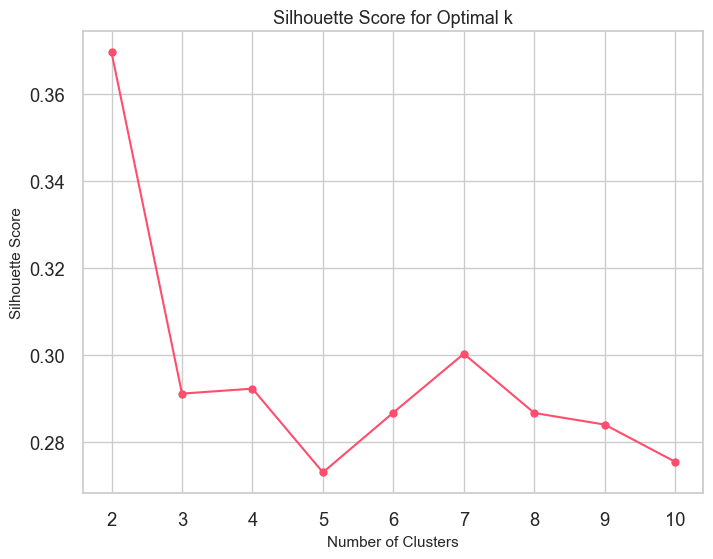

In [62]:
# Implement Silhouette Method to Find Optimal Number of Clusters
silhouette_list = []
k_range = range(2,11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, max_iter=200)
    y_pred = kmeans.fit_predict(pca_customer_data)
    
    silhouette = silhouette_score(pca_customer_data, y_pred)
    silhouette_list.append(silhouette)

print(silhouette_list)
# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_list, marker='o', color='#ff4d6d')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

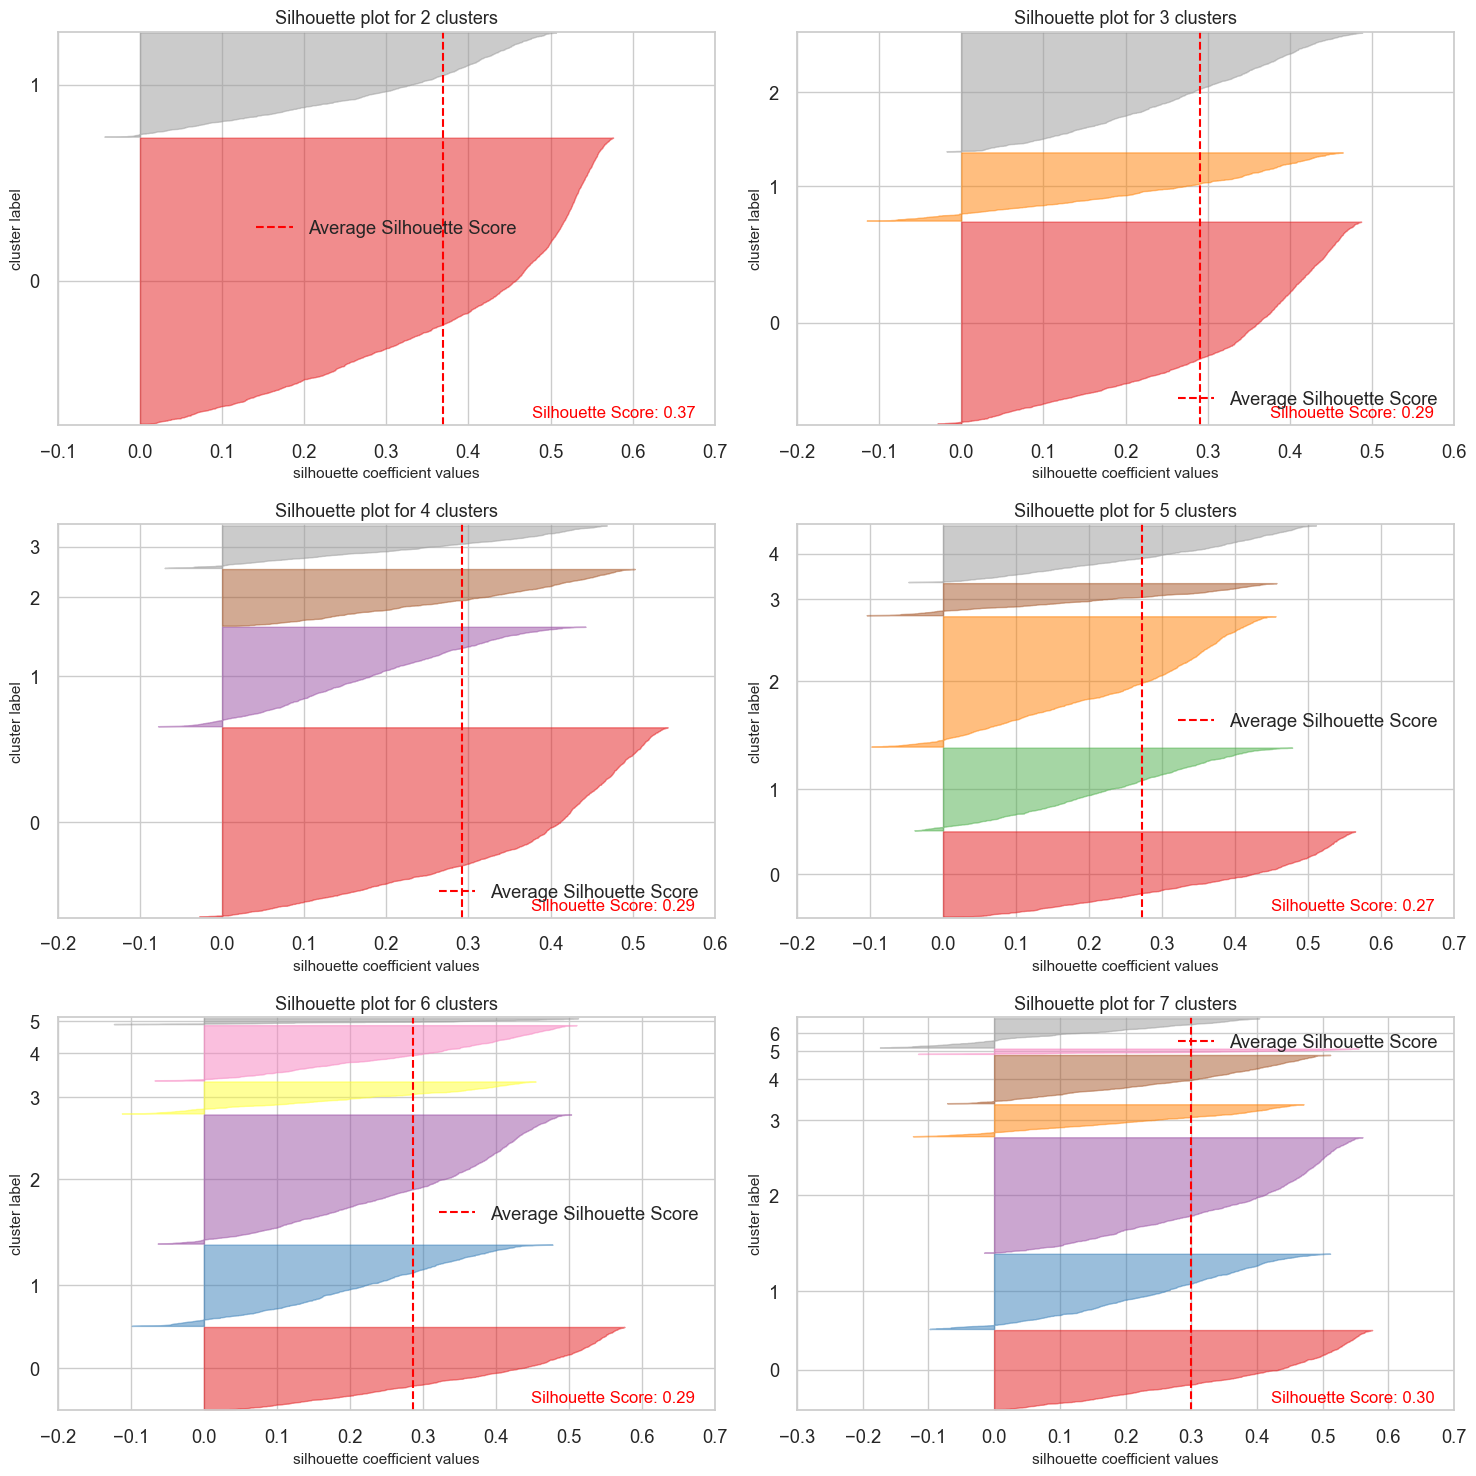

In [63]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for n_clusters in range(2, 8):
    ax = axes[n_clusters - 2]
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, max_iter=200)
    visualizer = SilhouetteVisualizer(kmeans, ax=ax)
    visualizer.fit(pca_customer_data)
    visualizer.finalize()
    ax.set_title(f'Silhouette plot for {n_clusters} clusters')
    score = silhouette_score(pca_customer_data, kmeans.labels_)
    ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')
plt.tight_layout()
plt.show()

<div style="border-radius:20px; padding: 10px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">

**Choosing the Optimal Number of Clusters**

In the customer segmentation project, determining the optimal number of clusters was a key step to ensure meaningful and interpretable customer groups. We used three techniques: the Elbow Method, Silhouette Score, and Silhouette Diagram, applied to a PCA-transformed dataset.

* Elbow Method: We ran the K-Means algorithm for cluster numbers 1 to 10, calculating the Within-Cluster Sum of Squares (WCSS) each time. WCSS measures the variance within clusters, decreasing as clusters increase. Plotting WCSS against the number of clusters showed a bend at 3 clusters.

* Silhouette Score: we calculated the Silhouette Score for cluster numbers 2 to 10. This metric, ranging from -1 to 1, assesses how well-separated and cohesive clusters are. The score peaked at 3 clusters with a value of ~0.3, suggesting reasonable separation and supporting the Elbow Method’s finding.

* Silhouette Diagram: For a visual check, we used silhouette diagrams to plot individual Silhouette Scores for the 3-cluster setup. Most customers had positive scores.

Based on these analyses, we selected 3 clusters as the optimal number, ensuring statistical rigor and practical utility.

<div style=" background-color: #ff8fa3; color:#ffffff; padding: 4px; border-radius: 0px 0px 30px 30px; text-align: center; font-size: 110%; font-family: sans-serif; width: 60%">

### Step 7-2 | Build The Models

In [64]:
# Optimal K of Cluster is = 3

In [65]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=200, random_state=42)
kmeans.fit(pca_customer_data)
labels = kmeans.labels_

customer_data['Cluster'] = labels
pca_customer_data['Cluster'] = labels

In [66]:
print(Counter(labels))

Counter({0: 2026, 2: 1190, 1: 684})


In [67]:
pca_customer_data.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,Cluster
0,4.78,-0.52,0.50,0.43,-0.01,-0.76,1
1,1.91,1.85,2.10,0.55,0.79,-0.70,2
2,0.89,-2.97,1.15,-2.54,1.82,-0.10,0
3,-2.20,-0.95,-0.12,1.31,0.56,-0.06,0
4,1.35,0.96,-0.18,0.18,-0.33,-0.12,2
5,-2.39,-0.18,-0.27,0.69,-0.38,-0.16,0
6,-0.38,-2.63,0.73,-0.31,1.92,0.08,0
7,-1.72,-1.07,0.67,0.38,0.25,-0.05,0
8,2.49,-0.06,1.75,-0.66,1.04,-0.25,1
9,-0.13,1.66,1.93,-1.06,0.52,0.10,2


<div style="border-radius:20px; padding: 10px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">

**Model Building**

With the number of clusters set, we built the K-Means model, initialized with n_clusters=3 and random_state=42 for reproducibility. The model was fitted to the PCA-transformed dataset containing 6 principal components derived from customer features. It assigned each of the customers to one of three clusters based on Euclidean distance to cluster centroids. These assignments were added to the original dataset, enabling further analysis and targeted marketing strategies.

<div style=" background-color: #ff4d6d; color:#ffffff; padding: 4px; border-radius: 15px; text-align: center; font-size: 110%; font-family: sans-serif">

## Step 8 | Models Evaluation and Visualization

In [68]:
features = customer_data.drop('CustomerID', axis=1).columns

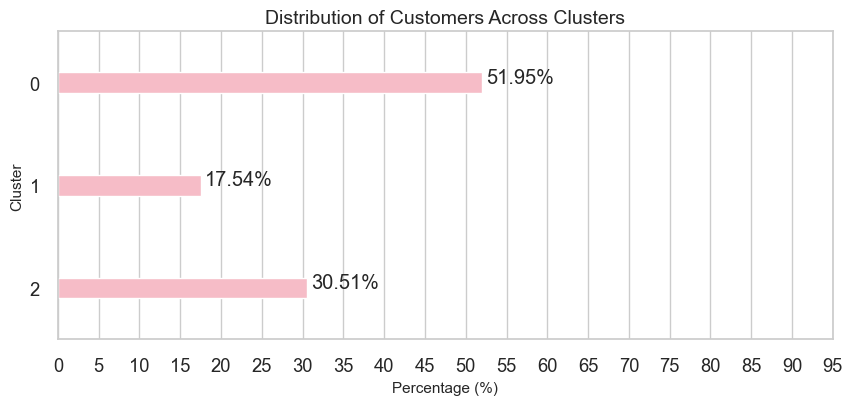

In [69]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (pca_customer_data['Cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', width=0.2)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 100, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

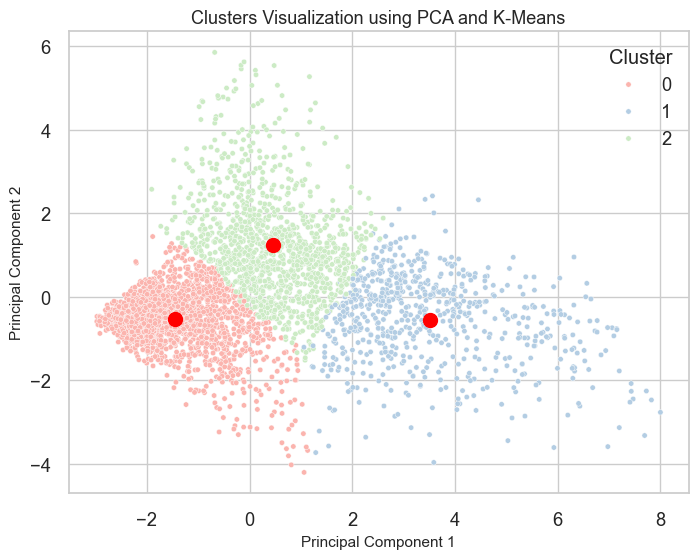

In [70]:
# Visualizing clusters (for first two principal components)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_customer_data['PC1'], y=pca_customer_data['PC2'], hue=pca_customer_data['Cluster'], palette='Pastel1', s=15)
centroids = pca_customer_data.groupby('Cluster')[['PC1', 'PC2']].mean()
plt.scatter(centroids['PC1'], centroids['PC2'], s=100, c='red', marker='o', 
            label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters Visualization using PCA and K-Means')
plt.show()

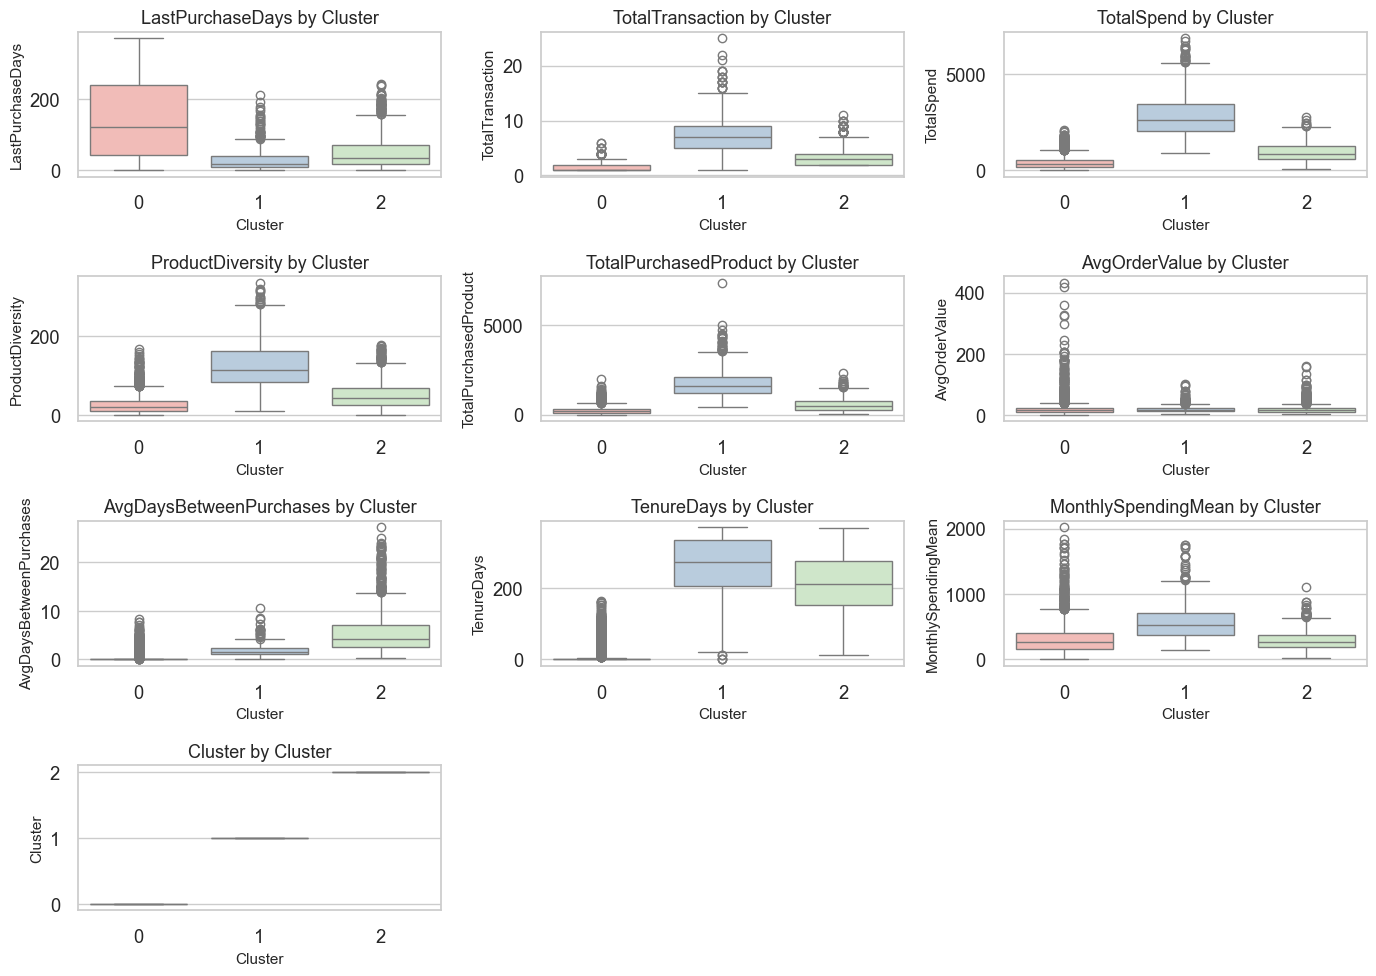

In [71]:
# --- Feature Importance: Box Plots ---
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='Cluster', y=feature, data=customer_data, palette='Pastel1')
    plt.title(f'{feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

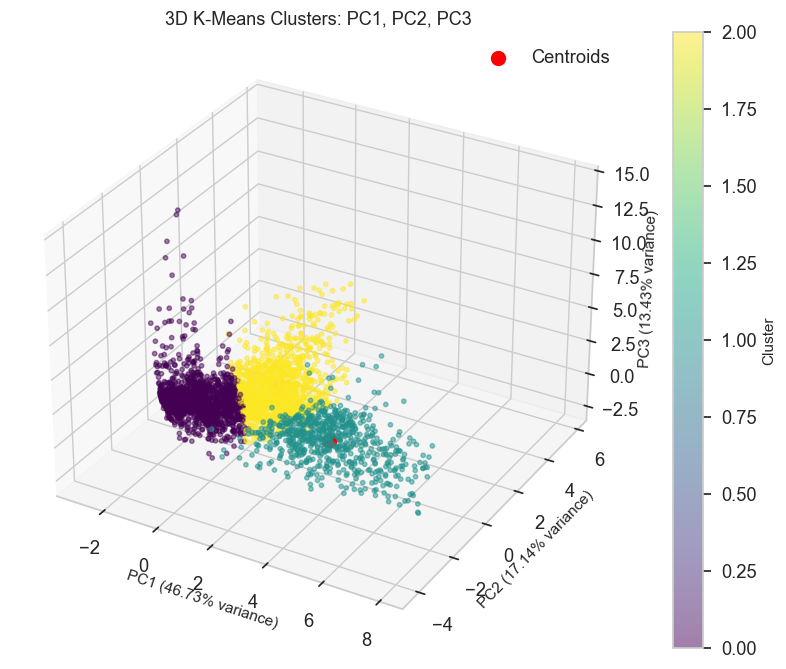

In [72]:
# --- 3D Visualization (PC1, PC2, PC3) ---

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot centroids
centroids = pca_customer_data.groupby('Cluster')[['PC1', 'PC2', 'PC3']].mean()
ax.scatter(centroids['PC1'], centroids['PC2'], centroids['PC3'],
           s=100, c='red', marker='o', label='Centroids')

# Scatter plot of points
scatter = ax.scatter(pca_customer_data['PC1'], pca_customer_data['PC2'], pca_customer_data['PC3'],
                    c=pca_customer_data['Cluster'], cmap='viridis', alpha=0.5, s=10)

# Set labels with explained variance
ax.set_xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
ax.set_ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
ax.set_zlabel(f'PC3 ({explained_variance[2]:.2%} variance)')
ax.set_title('3D K-Means Clusters: PC1, PC2, PC3')

# Add colorbar and legend
fig.colorbar(scatter, label='Cluster')
ax.legend()
plt.show()

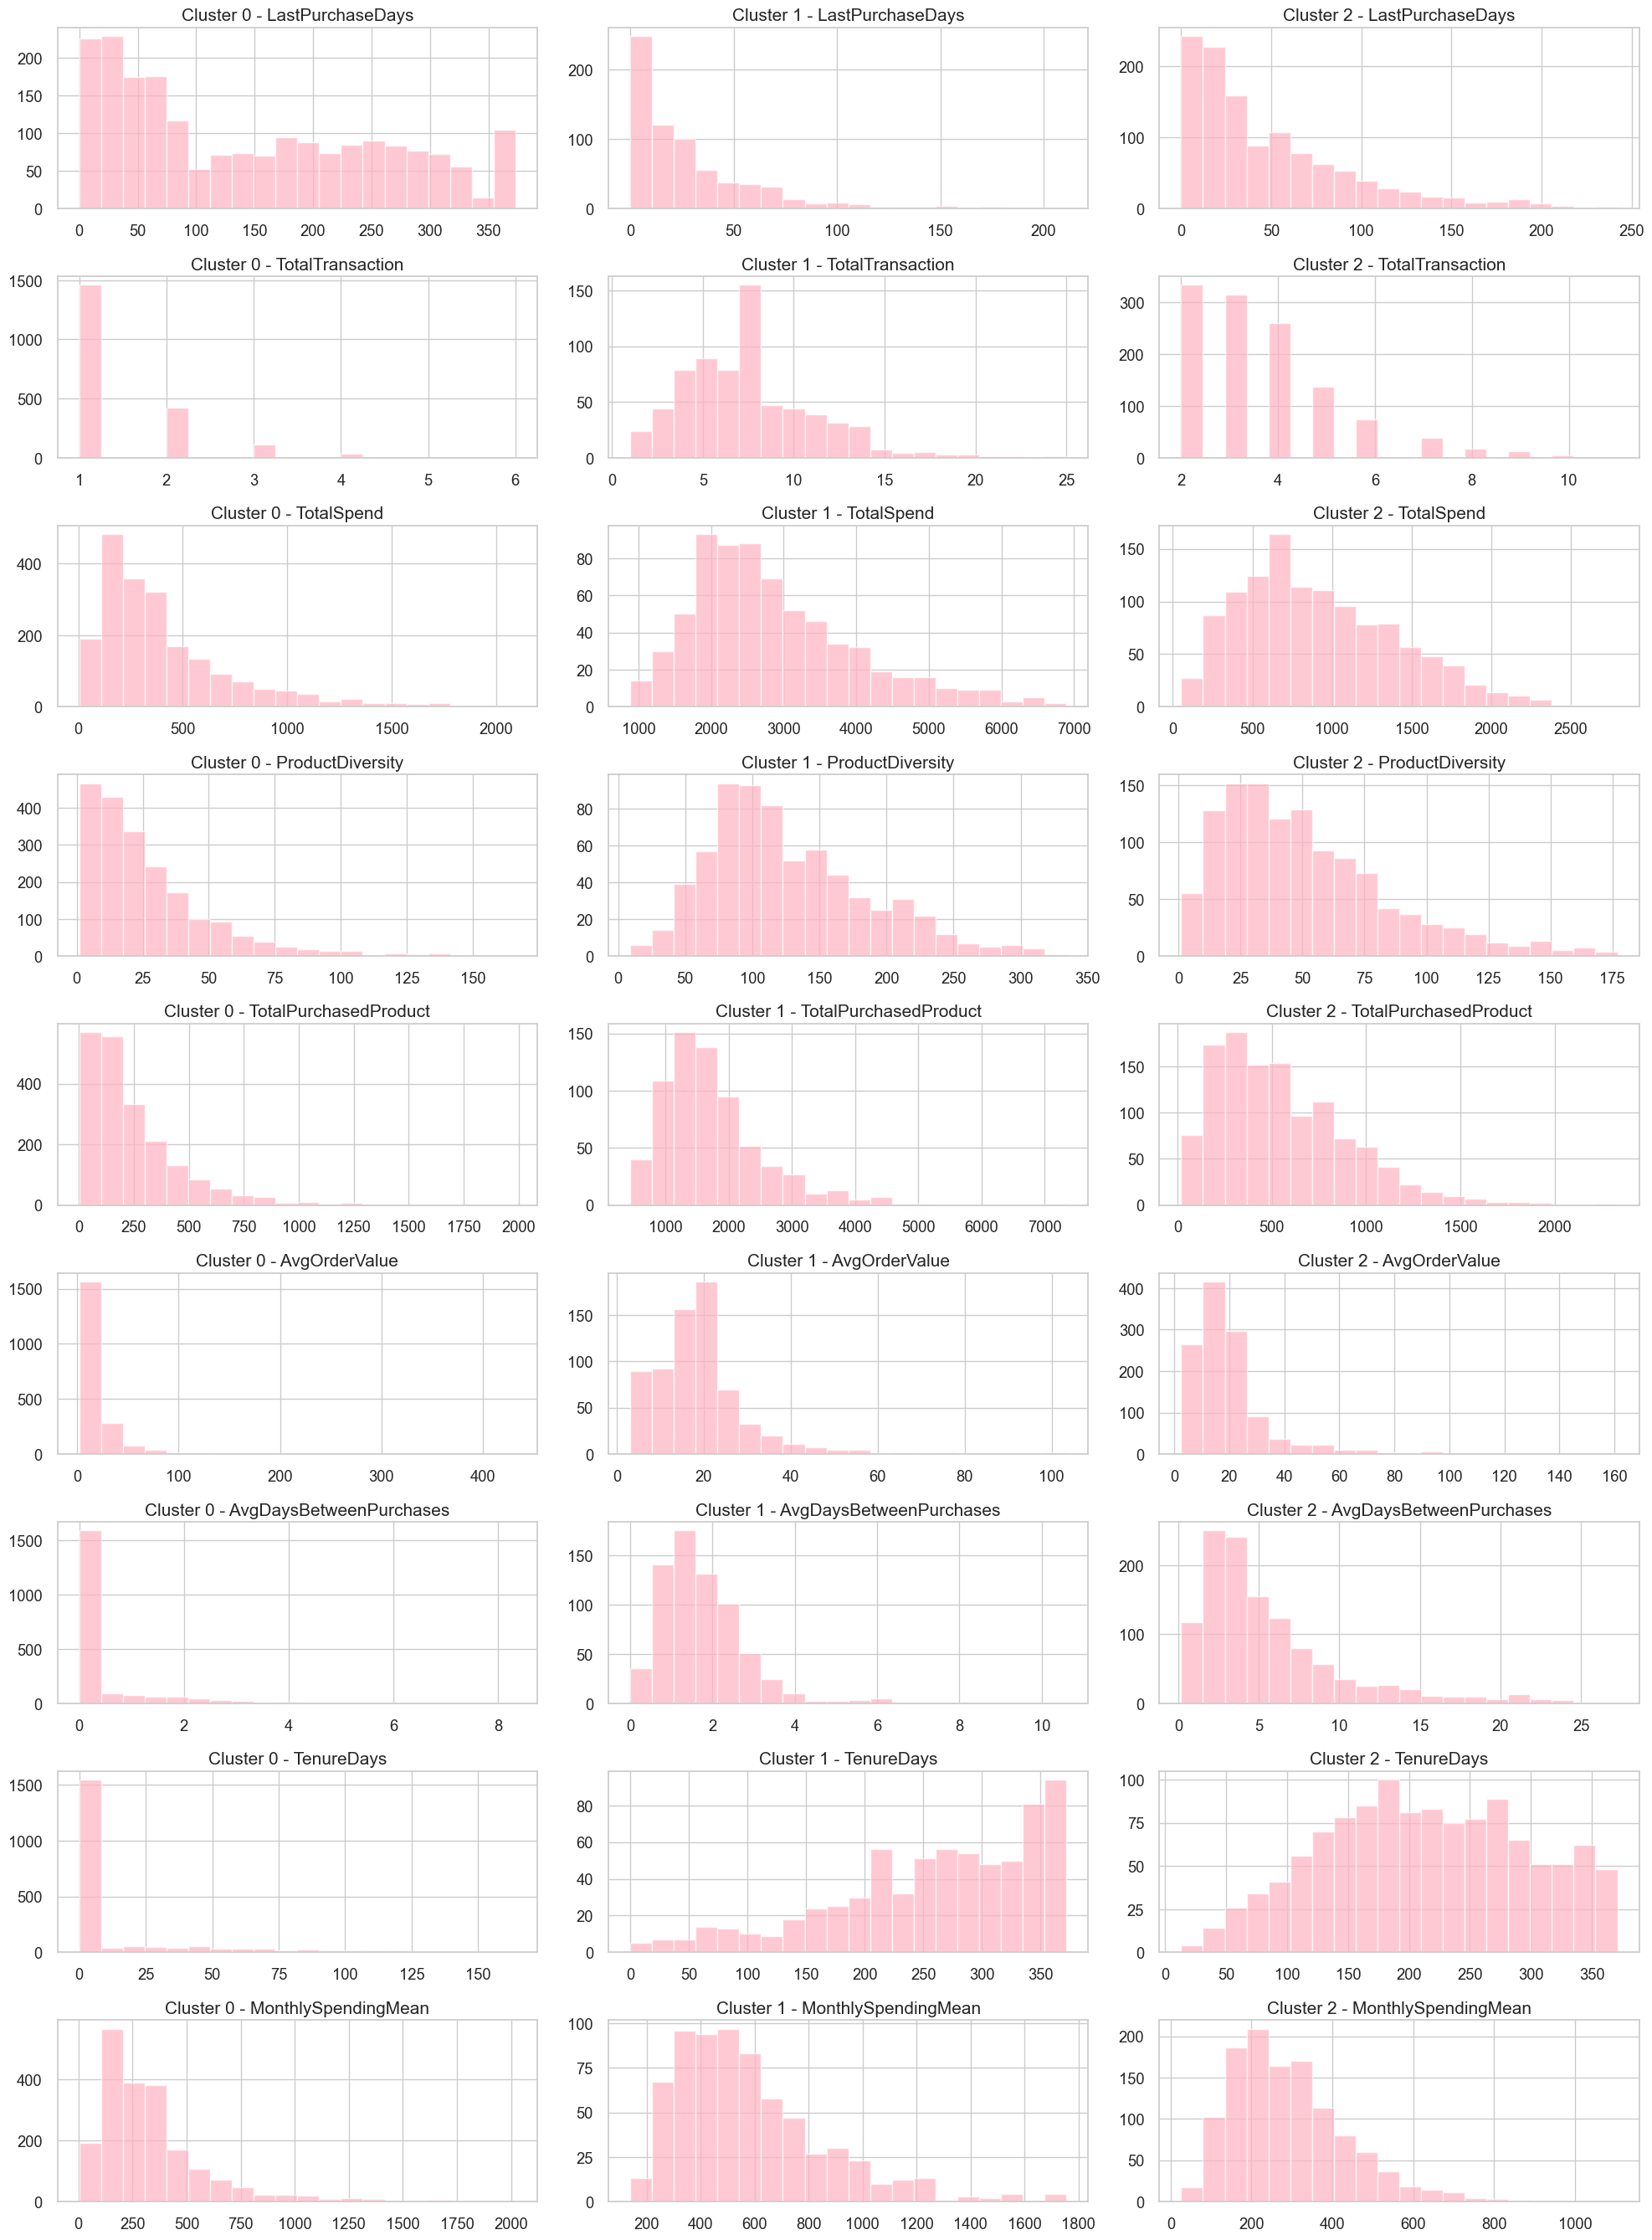

In [73]:
# Plot histograms for each feature segmented by the clusters
features = customer_data.columns[1:-1]
clusters = customer_data['Cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data[customer_data['Cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

In [74]:
# Model Evaluation:

X = pca_customer_data.drop('Cluster', axis=1)
clusters = pca_customer_data['Cluster']

# Compute the metrics
silhouette_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Silhouette Score", silhouette_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

table_data = pd.DataFrame(table_data, columns=['Metric', 'Value'])

In [75]:
table_data

,Metric,Value
0,Silhouette Score,0.29
1,Calinski Harabasz Score,1728.99
2,Davies Bouldin Score,1.27


In [76]:
# --- Feature Importance: Mean Differences ---
cluster_means = customer_data.groupby('Cluster')[features].mean()
print("\nMean Feature Values by Cluster:")
cluster_means


Mean Feature Values by Cluster:


,LastPurchaseDays,TotalTransaction,TotalSpend,ProductDiversity,TotalPurchasedProduct,AvgOrderValue,AvgDaysBetweenPurchases,TenureDays,MonthlySpendingMean
Cluster,,,,,,,,,
0,144.91,1.37,405.95,26.71,241.73,23.39,0.42,13.56,326.90
1,28.90,7.36,2867.48,126.62,1741.89,19.44,1.76,258.95,579.78
2,49.73,3.65,922.11,50.84,551.55,20.32,5.57,213.29,291.19


In [77]:
# --- Feature Importance: Median Differences ---
cluster_means = customer_data.groupby('Cluster')[features].median()
print("\nMedian Feature Values by Cluster:")
cluster_means


Median Feature Values by Cluster:


,LastPurchaseDays,TotalTransaction,TotalSpend,ProductDiversity,TotalPurchasedProduct,AvgOrderValue,AvgDaysBetweenPurchases,TenureDays,MonthlySpendingMean
Cluster,,,,,,,,,
0,121.50,1.00,314.16,20.00,176.50,16.71,0.00,0.00,271.12
1,18.00,7.00,2612.36,112.50,1591.00,18.25,1.57,273.00,525.89
2,33.00,3.00,840.64,43.00,486.00,17.19,4.17,211.00,267.93


<div style="border-radius:20px; padding: 10px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">

<h2>Cluster Characteristics:</h2>

The median feature values per cluster reveal distinct customer segments. Here’s a detailed analysis of each:

* **Cluster 1: Highly Active, High-Spending Customers(17.5% of total)**

- LastPurchaseDays: 18 (very recent)
- TotalTransaction: 7 (frequent)
- TotalSpend: 2612.36 (high)
- ProductDiversity: 112.5 (very diverse)
- TotalPurchasedProduct: 1591 (high volume)
- AvgOrderValue: 18.25
- AvgDaysBetweenPurchases: 1.57 (very frequent)
- TenureDays: 273 (long tenure)
- MonthlySpendingMean: 525.89 (high)
    - _**Insight:** These are your most valuable customers. They shop frequently, spend significantly, and buy a wide variety of products. Their recent activity and long tenure suggest strong loyalty._
    - _**Characteristics:** Frequent purchases, high spending, diverse product engagement, long tenure, and recent activity._
    - _**Business Perspective:** These are your top-tier customers. They drive significant revenue and are likely loyal. Focus on retaining them._

__Cluster 2: Moderately Active Customers(30.5% of total)__

  - LastPurchaseDays: 33 (recent)
  - TotalTransaction: 3 (moderate frequency)
  - TotalSpend: 840.64 (moderate)
  - ProductDiversity: 43 (moderate diversity)
  - TotalPurchasedProduct: 486 (moderate volume)
  - AvgOrderValue: 17.19
  - AvgDaysBetweenPurchases: 4.17 (somewhat frequent)
  - TenureDays: 211 (moderate tenure)
  - MonthlySpendingMean: 267.93 (moderate)
    - _**Insight:** These customers are regular but not top-tier. They purchase somewhat frequently and spend moderately, showing potential for increased engagement._
    - _**Characteristics:** Moderate purchase frequency, spending, and diversity, with decent tenure and recent activity._
    - _**Business Perspective:** These are regular customers with growth potential. They could be nudged toward higher engagement._

__Cluster 0: Inactive or One-Time Customers(52% of total)__
  - LastPurchaseDays: 121.5 (long time since last purchase)
  - TotalTransaction: 1 (single transaction)
  - TotalSpend: 314.16 (low)
  - ProductDiversity: 20 (low diversity)
  - TotalPurchasedProduct: 176.5 (low volume)
  - AvgOrderValue: 16.71
  - AvgDaysBetweenPurchases: 0 (likely one-time buyers)
  - TenureDays: 0 (new or one-time customers)
  - MonthlySpendingMean: 271.12 (low)
    - _**Insight:** This cluster represents inactive or one-time customers. They made a single purchase long ago and haven’t returned, indicating a high risk of churn._
    - _**Characteristics:** Single purchase, low spending, minimal diversity, and no recent activity._
    - _**Business Perspective:** These are at-risk customers. They need re-engagement to prevent permanent churn._

<div style="border-radius:20px; padding: 10px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">

<h2>Practical Applications:</h2>

__Cluster 1 (Highly Active, High-Spending Customers):__
* Strategy: Retention and maximization of lifetime value.
* Actions:
    - Loyalty Program: Offer VIP perks or rewards to maintain their engagement.
    - Cross-Sell: Recommend new product categories based on their diversity.
    - Upsell: Promote premium or high-margin items.

__Cluster 2 (Moderately Active Customers):__
* Strategy: Increase engagement and spending.
* Actions:
    - Targeted Promotions: Offer bundle deals or discounts to boost frequency.
    - Cross-Sell: Suggest complementary products to their moderate diversity.
    - Incentives: Provide small rewards for repeat purchases.

__Cluster 0 (Inactive or One-Time Customers):__
* Strategy: Re-engagement and reactivation.
* Actions:
    - Discounts: Offer significant incentives for their next purchase.
    - Email Campaigns: Send personalized reminders or product suggestions.
    - Ads: Target them with low-spend promotions to encourage a second purchase.

<div style=" background-color: #ff4d6d; color:#ffffff; padding: 4px; border-radius: 15px; text-align: center; font-size: 110%; font-family: sans-serif">

## Step 9 | Recommendation System

In [78]:
# Precompute popular products per cluster

# Remove outliers from our transaction dataset
outliers_id = outliers_data['CustomerID'].unique()
transactions_df = dataset[~dataset['CustomerID'].isin(outliers_id)]

# Merge transactions_df with customer_data to include Cluster information
merged_transactions = transactions_df.merge(customer_data[['CustomerID', 'Cluster']], on='CustomerID', how='inner')

# Precompute 10 most popular products per cluster based on total quantity
popular_products = {}
for cluster in customer_data['Cluster'].unique():
    # Get transactions for this cluster
    cluster_transactions = merged_transactions[merged_transactions['Cluster'] == cluster]
    # Sum total quantity per product and sort by quantity
    best_product = cluster_transactions.groupby(['Cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
    best_product = best_product.sort_values(['Cluster', 'Quantity'], ascending=[True, False])
    # Save top 10 products per cluster
    popular_products[cluster] = best_product.head(10)

# Convert popular_products to a DataFrame
popular_products_df = pd.concat(popular_products.values(), ignore_index=True)

In [79]:
#10 Best products per each cluster(0, 1, 2)
popular_products_df.sort_values(["Cluster", 'Quantity'], ascending=[True, False])

,Cluster,StockCode,Description,Quantity
20,0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,3756
21,0,84879,ASSORTED COLOUR BIRD ORNAMENT,3061
22,0,84568,GIRLS ALPHABET IRON ON PATCHES,2880
23,0,21212,PACK OF 72 RETROSPOT CAKE CASES,2724
24,0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2576
25,0,22492,MINI PAINT SET VINTAGE,2268
26,0,16045,POPART WOODEN PENCILS ASST,2200
27,0,22178,VICTORIAN GLASS HANGING T-LIGHT,1987
28,0,22577,WOODEN HEART CHRISTMAS SCANDINAVIAN,1923
29,0,84946,ANTIQUE SILVER T-LIGHT GLASS,1844


In [80]:
def products_recmmendation(customer_id):
    """
    Recommend three products to a customer based on their cluster's popular products.
    Args:
        customer_id: ID of the customer
    Returns:
        List of [StockCode, Description] for three recommended products
    """
    # Get customer's cluster
    cluster = customer_data[customer_data['CustomerID'] == customer_id]['Cluster'].values[0]
    # Get popular products for the cluster
    popular = popular_products[cluster]
    # Get products the customer has purchased
    purchased = set(transactions_df[transactions_df['CustomerID'] == customer_id]['StockCode'])
    # Filter out purchased products and take top 3
    recommended = popular[~popular['StockCode'].isin(purchased)].head(3)
    return recommended[['StockCode', 'Description']].values.tolist()

In [81]:
# Example usage
sample_customer = 16682
recommendations = products_recmmendation(sample_customer)
print(f"3 Recommendations for customer {sample_customer}:")
for stockcode, description in recommendations:
    print(f"* StockCode: {stockcode} --- Descrption: {description}")

3 Recommendations for customer 16682:
* StockCode: 84077 --- Descrption: WORLD WAR 2 GLIDERS ASSTD DESIGNS
* StockCode: 84879 --- Descrption: ASSORTED COLOUR BIRD ORNAMENT
* StockCode: 85123A --- Descrption: WHITE HANGING HEART T-LIGHT HOLDER


<div style="border-radius:20px; padding: 10px; background-color: #ffccd5; font-size:105%; text-align:left; font-family: sans-serif">

**Description:**

This system capitalized on the customer segments established through K-Means clustering—Cluster 1 (Highly Active, High-Spending Customers), Cluster 2 (Moderately Active Customers), and Cluster 0 (Inactive or One-Time Customers)—to recommend products that resonate with the purchasing behaviors of each group.
The process began with determining the most popular products for each cluster, using total quantity sold as the key metric to capture both purchase frequency and volume.Finally, by identifying the most popular products for each cluster, we provide recommendations based on the most popular products to the customers in that cluster.(recommend popular product that they haven't bought. )